# Multi-output Gaussian processes in GPflow

This notebook shows how to construct a multi-output GP model using GPflow, together with different interdomain inducing variables which lead to different approximation properties. GPflow provides a framework for specifying multioutput GP priors, and interdomain approximations which is
- modular, by providing a consistent interface for the user of the resulting `SVGP` model,
- extensible, by allowing new interdomain variables and kernels to be specified while reusing exising code where possible,
- efficient, by allowing the most efficient custom code path to be specified where desired.

Getting to grips with the maths and code can be a bit daunting, so to accompany the documentation there is an [in-depth review on arXiv](https://arxiv.org/abs/2003.01115), which provides a unified mathematical framework, together with a high-level description of software design choices in GPflow.

This notebook shows the various design choices that can be made, to show the reader the flexibility of the framework. This is done in the hope that an example is provided that can be easily adapted to the special case that the reader wants to implement.

A reader who just wants to use a multioutput kernel should simply choose the most efficient set of inducing variables.

To cite this framework, please reference our [arXiv paper](https://arxiv.org/abs/2003.01115).
```
@article{GPflow2020multioutput,
  author = {{van der Wilk}, Mark and Dutordoir, Vincent and John, ST and
            Artemev, Artem and Adam, Vincent and Hensman, James},
  title = {A Framework for Interdomain and Multioutput {G}aussian Processes},
  year = {2020},
  journal = {arXiv:2003.01115},
  url = {https://arxiv.org/abs/2003.01115}
}
```

\begin{equation}
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
\end{equation}



## Task
We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, that is, we observe all the outputs for a particular input location (for cases where there are **not** fully observed outputs for each input, see [A simple demonstration of coregionalization](./coregionalisation.ipynb)).

Here we assume a model of the form:
\begin{equation}
f(x) = W g(x),
\end{equation}
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and that by *mixing* them with $W$ they become correlated. In this notebook, we show how to build this model using Sparse Variational Gaussian Process (SVGP) for $g$, which scales well with the numbers of data points and outputs.

Here we have two options for $g$:
1. The output dimensions of $g$ share the same kernel.
1. Each output of $g$ has a separate kernel.


In addition, we have two further suboptions for the inducing inputs of $g$:
1. The instances of $g$ share the same inducing inputs.
1. Each output of $g$ has its own set of inducing inputs.

The notation is as follows:
- $X \in \mathbb{R}^{N \times D}$ denotes the input
- $Y \in \RR^{N \times P}$ denotes the output
- $k_{1..L}$, $L$ are kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ are independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ are correlated  $\GP$s  with $\vf = \vW \vg$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

2022-03-18 09:41:31.947330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 09:41:31.947358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [2]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

    return X, Y

In [4]:
X, Y = data = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

## Model the outputs of $f(x)$ directly
The three following examples show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
\begin{equation}
f(x) = I g(x),
\end{equation}
i.e. $W = I$ and $P = L$.

### 1. Shared independent multi-output kernel (MOK) and shared independent inducing variables
Here the priors on all outputs are constrained to have the same kernel hyperparameters. We also share the inducing inputs between all outputs. The different GPs are independent both in the prior and the approximate posterior.

In [6]:
# create multi-output kernel
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

2022-03-18 09:41:33.910529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-18 09:41:33.910558: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-18 09:41:33.910580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8133e5b35d16): /proc/driver/nvidia/version does not exist
2022-03-18 09:41:33.910845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-5....
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1., 0., 0...."


In [8]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

2022-03-18 09:41:33.981164: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-18 09:41:38.449391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          424     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26251D+03    |proj g|=  1.79322D+03

At iterate    1    f=  1.42381D+03    |proj g|=  5.94444D+02

At iterate    2    f=  8.84935D+02    |proj g|=  3.56771D+02

At iterate    3    f=  5.15138D+02    |proj g|=  5.86730D+01

At iterate    4    f=  4.91599D+02    |proj g|=  4.57648D+01

At iterate    5    f=  4.83878D+02    |proj g|=  4.25475D+01

At iterate    6    f=  4.55434D+02    |proj g|=  2.73693D+01

At iterate    7    f=  4.20808D+02    |proj g|=  5.49701D+01

At iterate    8    f=  4.04327D+02    |proj g|=  7.51807D+01

At iterate    9    f=  3.80875D+02    |proj g|=  5.05081D+01

At iterate   10    f=  3.60975D+02    |proj g|=  4.18280D+01

At iterate   11    f=  3.56982D+02    |proj g|=  2.16764D+01

At iterate   12    f=  3.46620D+02    |proj g|=  4.81397D+01

At iterate   13    f=  3.4


At iterate  145    f=  5.50693D+01    |proj g|=  1.41916D+01

At iterate  146    f=  5.49787D+01    |proj g|=  3.06606D+01

At iterate  147    f=  5.48239D+01    |proj g|=  1.17267D+01

At iterate  148    f=  5.47251D+01    |proj g|=  9.40771D+00

At iterate  149    f=  5.46502D+01    |proj g|=  1.59464D+01

At iterate  150    f=  5.45630D+01    |proj g|=  1.93344D+01

At iterate  151    f=  5.44698D+01    |proj g|=  8.44037D+00

At iterate  152    f=  5.44024D+01    |proj g|=  7.66396D+00

At iterate  153    f=  5.43429D+01    |proj g|=  1.34224D+01

At iterate  154    f=  5.42487D+01    |proj g|=  1.80182D+01

At iterate  155    f=  5.41473D+01    |proj g|=  9.90692D+00

At iterate  156    f=  5.40602D+01    |proj g|=  7.29362D+00

At iterate  157    f=  5.39986D+01    |proj g|=  1.17505D+01

At iterate  158    f=  5.39233D+01    |proj g|=  1.42544D+01

At iterate  159    f=  5.38337D+01    |proj g|=  1.74372D+01

At iterate  160    f=  5.37372D+01    |proj g|=  1.91559D+01

At iter


At iterate  295    f=  4.68017D+01    |proj g|=  1.16292D+01

At iterate  296    f=  4.67739D+01    |proj g|=  1.34242D+01

At iterate  297    f=  4.67486D+01    |proj g|=  4.78430D+00

At iterate  298    f=  4.67405D+01    |proj g|=  3.77039D+00

At iterate  299    f=  4.67026D+01    |proj g|=  5.85727D+00

At iterate  300    f=  4.66833D+01    |proj g|=  1.93983D+01

At iterate  301    f=  4.66562D+01    |proj g|=  1.09632D+01

At iterate  302    f=  4.66191D+01    |proj g|=  3.80485D+00

At iterate  303    f=  4.65800D+01    |proj g|=  1.09036D+01

At iterate  304    f=  4.65473D+01    |proj g|=  1.05792D+01

At iterate  305    f=  4.65242D+01    |proj g|=  6.91986D+00

At iterate  306    f=  4.65074D+01    |proj g|=  1.16128D+01

At iterate  307    f=  4.64925D+01    |proj g|=  6.37754D+00

At iterate  308    f=  4.64743D+01    |proj g|=  1.12283D+01

At iterate  309    f=  4.64514D+01    |proj g|=  1.35280D+01

At iterate  310    f=  4.64232D+01    |proj g|=  7.62627D+00

At iter


At iterate  439    f=  4.40460D+01    |proj g|=  1.76756D+00

At iterate  440    f=  4.40351D+01    |proj g|=  6.53100D+00

At iterate  441    f=  4.40221D+01    |proj g|=  7.79095D+00

At iterate  442    f=  4.40117D+01    |proj g|=  1.71590D+01

At iterate  443    f=  4.39903D+01    |proj g|=  6.92500D+00

At iterate  444    f=  4.39709D+01    |proj g|=  4.01262D+00

At iterate  445    f=  4.39577D+01    |proj g|=  8.42713D+00

At iterate  446    f=  4.39466D+01    |proj g|=  6.70936D+00

At iterate  447    f=  4.39376D+01    |proj g|=  3.71329D+00

At iterate  448    f=  4.39221D+01    |proj g|=  4.06579D+00

At iterate  449    f=  4.39118D+01    |proj g|=  5.16542D+00

At iterate  450    f=  4.39014D+01    |proj g|=  2.59145D+00

At iterate  451    f=  4.38813D+01    |proj g|=  8.93880D+00

At iterate  452    f=  4.38673D+01    |proj g|=  1.47488D+01

At iterate  453    f=  4.38522D+01    |proj g|=  7.02170D+00

At iterate  454    f=  4.38368D+01    |proj g|=  2.78464D+00

At iter


At iterate  588    f=  4.27150D+01    |proj g|=  4.71851D+00

At iterate  589    f=  4.27122D+01    |proj g|=  1.11988D+00

At iterate  590    f=  4.27106D+01    |proj g|=  1.90510D+00

At iterate  591    f=  4.27093D+01    |proj g|=  3.04942D+00

At iterate  592    f=  4.27077D+01    |proj g|=  2.92004D+00

At iterate  593    f=  4.27061D+01    |proj g|=  1.78629D+00

At iterate  594    f=  4.27051D+01    |proj g|=  2.47205D+00

At iterate  595    f=  4.27043D+01    |proj g|=  1.95061D+00

At iterate  596    f=  4.27010D+01    |proj g|=  3.11833D+00

At iterate  597    f=  4.26975D+01    |proj g|=  5.32663D+00

At iterate  598    f=  4.26958D+01    |proj g|=  2.49185D+00

At iterate  599    f=  4.26943D+01    |proj g|=  1.43013D+00

At iterate  600    f=  4.26929D+01    |proj g|=  2.01457D+00

At iterate  601    f=  4.26914D+01    |proj g|=  2.92685D+00

At iterate  602    f=  4.26888D+01    |proj g|=  2.80285D+00

At iterate  603    f=  4.26854D+01    |proj g|=  8.51832D+00

At iter

At iterate  738    f=  4.24738D+01    |proj g|=  1.21300D+00

At iterate  739    f=  4.24731D+01    |proj g|=  2.03357D+00

At iterate  740    f=  4.24727D+01    |proj g|=  1.73848D+00

At iterate  741    f=  4.24722D+01    |proj g|=  7.08300D-01

At iterate  742    f=  4.24711D+01    |proj g|=  2.20712D+00

At iterate  743    f=  4.24705D+01    |proj g|=  2.59564D+00

At iterate  744    f=  4.24699D+01    |proj g|=  4.16222D+00

At iterate  745    f=  4.24689D+01    |proj g|=  1.13398D+00

At iterate  746    f=  4.24685D+01    |proj g|=  8.89656D-01

At iterate  747    f=  4.24677D+01    |proj g|=  2.50642D+00

At iterate  748    f=  4.24669D+01    |proj g|=  2.95238D+00

At iterate  749    f=  4.24664D+01    |proj g|=  3.21020D+00

At iterate  750    f=  4.24656D+01    |proj g|=  1.20735D+00

At iterate  751    f=  4.24650D+01    |proj g|=  7.96458D-01

At iterate  752    f=  4.24643D+01    |proj g|=  1.96955D+00

At iterate  753    f=  4.24636D+01    |proj g|=  2.49270D+00

At itera

At iterate  881    f=  4.24324D+01    |proj g|=  1.06529D+00

At iterate  882    f=  4.24323D+01    |proj g|=  4.62128D-01

At iterate  883    f=  4.24323D+01    |proj g|=  4.53043D-01

At iterate  884    f=  4.24322D+01    |proj g|=  4.61682D-01

At iterate  885    f=  4.24321D+01    |proj g|=  3.68043D-01

At iterate  886    f=  4.24320D+01    |proj g|=  1.00040D+00

At iterate  887    f=  4.24318D+01    |proj g|=  4.34740D-01

At iterate  888    f=  4.24317D+01    |proj g|=  1.41783D-01

At iterate  889    f=  4.24316D+01    |proj g|=  6.70658D-01

At iterate  890    f=  4.24315D+01    |proj g|=  4.75837D-01

At iterate  891    f=  4.24314D+01    |proj g|=  5.33285D-01

At iterate  892    f=  4.24312D+01    |proj g|=  6.88303D-01

At iterate  893    f=  4.24312D+01    |proj g|=  9.33401D-01

At iterate  894    f=  4.24311D+01    |proj g|=  3.90701D-01

At iterate  895    f=  4.24310D+01    |proj g|=  2.90286D-01

At iterate  896    f=  4.24309D+01    |proj g|=  4.01782D-01

At itera


At iterate 1034    f=  4.24237D+01    |proj g|=  4.19702D-01

At iterate 1035    f=  4.24237D+01    |proj g|=  1.88512D-01

At iterate 1036    f=  4.24236D+01    |proj g|=  1.79722D-01

At iterate 1037    f=  4.24236D+01    |proj g|=  3.46111D-01

At iterate 1038    f=  4.24236D+01    |proj g|=  3.70910D-01

At iterate 1039    f=  4.24236D+01    |proj g|=  5.07946D-01

At iterate 1040    f=  4.24236D+01    |proj g|=  1.03356D-01

At iterate 1041    f=  4.24236D+01    |proj g|=  1.46747D-01

At iterate 1042    f=  4.24236D+01    |proj g|=  3.19083D-01

At iterate 1043    f=  4.24236D+01    |proj g|=  3.65466D-01

At iterate 1044    f=  4.24235D+01    |proj g|=  4.48655D-01

At iterate 1045    f=  4.24235D+01    |proj g|=  2.20216D-01

At iterate 1046    f=  4.24235D+01    |proj g|=  8.52862D-02

At iterate 1047    f=  4.24235D+01    |proj g|=  2.11327D-01

At iterate 1048    f=  4.24235D+01    |proj g|=  2.72405D-01

At iterate 1049    f=  4.24235D+01    |proj g|=  3.73746D-01

At iter


At iterate 1188    f=  4.24224D+01    |proj g|=  3.68067D-01

At iterate 1189    f=  4.24224D+01    |proj g|=  5.39218D-01

At iterate 1190    f=  4.24224D+01    |proj g|=  3.93825D-01

At iterate 1191    f=  4.24224D+01    |proj g|=  2.20548D-01

At iterate 1192    f=  4.24224D+01    |proj g|=  6.06204D-02

At iterate 1193    f=  4.24224D+01    |proj g|=  1.72806D-01

At iterate 1194    f=  4.24224D+01    |proj g|=  3.26589D-01

At iterate 1195    f=  4.24224D+01    |proj g|=  4.53726D-01

At iterate 1196    f=  4.24224D+01    |proj g|=  2.54768D-01

At iterate 1197    f=  4.24223D+01    |proj g|=  8.04439D-02

At iterate 1198    f=  4.24223D+01    |proj g|=  1.26195D-01

At iterate 1199    f=  4.24223D+01    |proj g|=  2.24882D-01

At iterate 1200    f=  4.24223D+01    |proj g|=  4.20839D-01

At iterate 1201    f=  4.24223D+01    |proj g|=  1.51965D-01

At iterate 1202    f=  4.24223D+01    |proj g|=  1.16130D-01

At iterate 1203    f=  4.24223D+01    |proj g|=  1.84033D-01

At iter


At iterate 1345    f=  4.24215D+01    |proj g|=  1.99133D-01

At iterate 1346    f=  4.24215D+01    |proj g|=  1.10373D-01

At iterate 1347    f=  4.24215D+01    |proj g|=  1.32124D-01

At iterate 1348    f=  4.24215D+01    |proj g|=  1.23018D-01

At iterate 1349    f=  4.24215D+01    |proj g|=  4.23514D-01

At iterate 1350    f=  4.24215D+01    |proj g|=  9.17573D-02

At iterate 1351    f=  4.24215D+01    |proj g|=  6.97844D-02

At iterate 1352    f=  4.24215D+01    |proj g|=  1.43900D-01

At iterate 1353    f=  4.24215D+01    |proj g|=  1.36241D-01

At iterate 1354    f=  4.24215D+01    |proj g|=  7.16874D-02

At iterate 1355    f=  4.24215D+01    |proj g|=  1.14832D-01

At iterate 1356    f=  4.24215D+01    |proj g|=  1.19602D-01

At iterate 1357    f=  4.24215D+01    |proj g|=  1.79030D-01

At iterate 1358    f=  4.24214D+01    |proj g|=  1.32197D-01

At iterate 1359    f=  4.24214D+01    |proj g|=  7.10713D-02

At iterate 1360    f=  4.24214D+01    |proj g|=  3.61676D-02

At iter


At iterate 1499    f=  4.24208D+01    |proj g|=  8.56919D-02

At iterate 1500    f=  4.24207D+01    |proj g|=  1.18199D-01

At iterate 1501    f=  4.24207D+01    |proj g|=  1.62792D-01

At iterate 1502    f=  4.24207D+01    |proj g|=  7.30586D-02

At iterate 1503    f=  4.24207D+01    |proj g|=  8.53077D-02

At iterate 1504    f=  4.24207D+01    |proj g|=  1.52951D-01

At iterate 1505    f=  4.24207D+01    |proj g|=  2.43766D-01

At iterate 1506    f=  4.24207D+01    |proj g|=  6.12102D-02

At iterate 1507    f=  4.24207D+01    |proj g|=  3.93848D-02

At iterate 1508    f=  4.24207D+01    |proj g|=  6.02719D-02

At iterate 1509    f=  4.24207D+01    |proj g|=  1.01558D-01

At iterate 1510    f=  4.24207D+01    |proj g|=  1.64875D-01

At iterate 1511    f=  4.24207D+01    |proj g|=  2.02699D-01

At iterate 1512    f=  4.24207D+01    |proj g|=  5.09900D-02

At iterate 1513    f=  4.24207D+01    |proj g|=  4.70872D-02

At iterate 1514    f=  4.24207D+01    |proj g|=  7.63515D-02

At iter


At iterate 1654    f=  4.24205D+01    |proj g|=  6.56533D-02

At iterate 1655    f=  4.24205D+01    |proj g|=  7.76320D-02

At iterate 1656    f=  4.24205D+01    |proj g|=  2.43468D-01

At iterate 1657    f=  4.24205D+01    |proj g|=  5.54016D-02

At iterate 1658    f=  4.24205D+01    |proj g|=  2.89542D-02

At iterate 1659    f=  4.24205D+01    |proj g|=  3.20565D-02

At iterate 1660    f=  4.24205D+01    |proj g|=  4.31769D-02

At iterate 1661    f=  4.24204D+01    |proj g|=  6.66769D-02

At iterate 1662    f=  4.24204D+01    |proj g|=  5.15272D-02

At iterate 1663    f=  4.24204D+01    |proj g|=  2.60835D-02

At iterate 1664    f=  4.24204D+01    |proj g|=  4.97254D-02

At iterate 1665    f=  4.24204D+01    |proj g|=  7.54156D-02

At iterate 1666    f=  4.24204D+01    |proj g|=  6.67869D-02

At iterate 1667    f=  4.24204D+01    |proj g|=  8.49123D-02

At iterate 1668    f=  4.24204D+01    |proj g|=  6.86658D-02

At iterate 1669    f=  4.24204D+01    |proj g|=  1.56114D-02

At iter

At iterate 1721    f=  4.24204D+01    |proj g|=  6.79420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  424   1721   1830      1     0     0   6.794D-02   4.242D+01
  F =   42.420418690543030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [9]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.92711712662142
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.798220033030666
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2124838651188536
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.039662607155263395
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-4.83965829...
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[-0.90150183, 0.69891397, -1.47472848..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1.71241092e-02, 0.00000000e+00, 0.00000000e+00..."


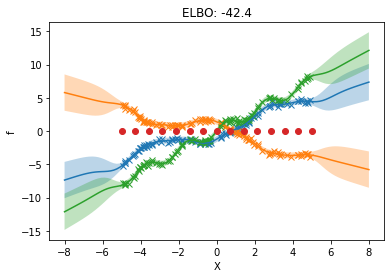

In [10]:
# Plot predictions and observations
plot_model(m)

In [11]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

name,class,transform,prior,trainable,shape,dtype,value
SharedIndependent.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.927117
SharedIndependent.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.79822
SharedIndependent.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.21248


<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.798220033030666>

### 2. Separate independent MOK and shared independent inducing variables
Here we allow different hyperparameters for the priors of each output. We still share the inducing inputs between all outputs.

In [12]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [13]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [14]:
optimize_model_with_scipy(m)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
Use fn_output_signature instead


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          430     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26251D+03    |proj g|=  1.79322D+03

At iterate    1    f=  1.42015D+03    |proj g|=  6.05642D+02

At iterate    2    f=  8.19715D+02    |proj g|=  3.33032D+02

At iterate    3    f=  5.14237D+02    |proj g|=  4.54683D+01

At iterate    4    f=  4.98740D+02    |proj g|=  2.71373D+01

At iterate    5    f=  4.92718D+02    |proj g|=  1.65071D+01

At iterate    6    f=  4.47862D+02    |proj g|=  5.66247D+01

At iterate    7    f=  4.12833D+02    |proj g|=  2.49963D+02

At iterate    8    f=  4.10017D+02    |proj g|=  1.03353D+02

At iterate    9    f=  4.00655D+02    |proj g|=  7.87041D+01

At iterate   10    f=  3.87640D+02    |proj g|=  5.53010D+01

At iterate   11    f=  3.80450D+02    |proj g|=  2.19475D+02

At iterate   12    f=  3.70241D+02    |proj g|=  5.67114D+01

At iterate   13    f=  3.6

At iterate   55    f=  1.92414D+02    |proj g|=  6.33214D+00

At iterate   56    f=  1.92259D+02    |proj g|=  9.57141D+00

At iterate   57    f=  1.92068D+02    |proj g|=  1.48452D+01

At iterate   58    f=  1.91647D+02    |proj g|=  2.12369D+01

At iterate   59    f=  1.91549D+02    |proj g|=  4.73479D+01

At iterate   60    f=  1.91016D+02    |proj g|=  1.19692D+01

At iterate   61    f=  1.90803D+02    |proj g|=  6.98499D+00

At iterate   62    f=  1.90642D+02    |proj g|=  9.37318D+00

At iterate   63    f=  1.90456D+02    |proj g|=  1.64678D+01

At iterate   64    f=  1.90245D+02    |proj g|=  1.73045D+01

At iterate   65    f=  1.90023D+02    |proj g|=  1.11901D+01

At iterate   66    f=  1.89812D+02    |proj g|=  1.23540D+01

At iterate   67    f=  1.89586D+02    |proj g|=  1.53468D+01

At iterate   68    f=  1.89363D+02    |proj g|=  5.21457D+00

At iterate   69    f=  1.89214D+02    |proj g|=  7.71463D+00

At iterate   70    f=  1.88975D+02    |proj g|=  1.68951D+01

At itera


At iterate  113    f=  1.24254D+02    |proj g|=  8.91084D+01

At iterate  114    f=  1.20659D+02    |proj g|=  8.68286D+01

At iterate  115    f=  1.18972D+02    |proj g|=  8.12514D+01

At iterate  116    f=  1.16638D+02    |proj g|=  3.91917D+01

At iterate  117    f=  1.14171D+02    |proj g|=  8.30333D+01

At iterate  118    f=  1.10977D+02    |proj g|=  1.21605D+02

At iterate  119    f=  1.08729D+02    |proj g|=  1.84619D+02

At iterate  120    f=  1.05531D+02    |proj g|=  4.04359D+01

At iterate  121    f=  1.04131D+02    |proj g|=  3.79307D+01

At iterate  122    f=  1.01372D+02    |proj g|=  8.27384D+01

At iterate  123    f=  9.78652D+01    |proj g|=  1.46572D+02

At iterate  124    f=  9.54512D+01    |proj g|=  1.12628D+02

At iterate  125    f=  9.24183D+01    |proj g|=  3.24605D+01

At iterate  126    f=  9.04065D+01    |proj g|=  4.07626D+01

At iterate  127    f=  8.86875D+01    |proj g|=  1.49560D+02

At iterate  128    f=  8.61240D+01    |proj g|=  7.13086D+01

At iter


At iterate  175    f=  5.39494D+01    |proj g|=  1.63724D+01

At iterate  176    f=  5.38019D+01    |proj g|=  1.74658D+01

At iterate  177    f=  5.35984D+01    |proj g|=  1.85524D+01

At iterate  178    f=  5.33539D+01    |proj g|=  4.66074D+01

At iterate  179    f=  5.31156D+01    |proj g|=  1.60498D+01

At iterate  180    f=  5.29752D+01    |proj g|=  9.96667D+00

At iterate  181    f=  5.28258D+01    |proj g|=  2.19878D+01

At iterate  182    f=  5.26144D+01    |proj g|=  2.61333D+01

At iterate  183    f=  5.23855D+01    |proj g|=  2.51493D+01

At iterate  184    f=  5.21666D+01    |proj g|=  1.91968D+01

At iterate  185    f=  5.20526D+01    |proj g|=  1.10995D+01

At iterate  186    f=  5.19171D+01    |proj g|=  1.59377D+01

At iterate  187    f=  5.15014D+01    |proj g|=  2.02127D+01

At iterate  188    f=  5.14020D+01    |proj g|=  3.54842D+01

At iterate  189    f=  5.12203D+01    |proj g|=  1.98365D+01

At iterate  190    f=  5.11300D+01    |proj g|=  6.20724D+00

At iter


At iterate  241    f=  4.72995D+01    |proj g|=  1.27074D+01

At iterate  242    f=  4.72641D+01    |proj g|=  1.13871D+01

At iterate  243    f=  4.72380D+01    |proj g|=  1.12551D+01

At iterate  244    f=  4.71407D+01    |proj g|=  1.18754D+01

At iterate  245    f=  4.71145D+01    |proj g|=  2.55527D+01

At iterate  246    f=  4.70572D+01    |proj g|=  1.06651D+01

At iterate  247    f=  4.70201D+01    |proj g|=  7.62275D+00

At iterate  248    f=  4.69845D+01    |proj g|=  8.08826D+00

At iterate  249    f=  4.69052D+01    |proj g|=  1.86841D+01

At iterate  250    f=  4.68656D+01    |proj g|=  1.89532D+01

At iterate  251    f=  4.67977D+01    |proj g|=  6.86764D+00

At iterate  252    f=  4.67511D+01    |proj g|=  5.49832D+00

At iterate  253    f=  4.67101D+01    |proj g|=  2.66040D+01

At iterate  254    f=  4.66595D+01    |proj g|=  7.60621D+00

At iterate  255    f=  4.66163D+01    |proj g|=  4.69072D+00

At iterate  256    f=  4.65437D+01    |proj g|=  1.34693D+01

At iter


At iterate  304    f=  4.45762D+01    |proj g|=  1.30275D+01

At iterate  305    f=  4.45403D+01    |proj g|=  6.31115D+00

At iterate  306    f=  4.45135D+01    |proj g|=  8.55854D+00

At iterate  307    f=  4.44977D+01    |proj g|=  1.57461D+01

At iterate  308    f=  4.44797D+01    |proj g|=  6.77931D+00

At iterate  309    f=  4.44541D+01    |proj g|=  6.14729D+00

At iterate  310    f=  4.44264D+01    |proj g|=  1.40203D+01

At iterate  311    f=  4.43996D+01    |proj g|=  6.99100D+00

At iterate  312    f=  4.43777D+01    |proj g|=  4.30004D+00

At iterate  313    f=  4.43492D+01    |proj g|=  5.65345D+00

At iterate  314    f=  4.43441D+01    |proj g|=  2.25182D+01

At iterate  315    f=  4.43137D+01    |proj g|=  5.01810D+00

At iterate  316    f=  4.43015D+01    |proj g|=  4.12333D+00

At iterate  317    f=  4.42862D+01    |proj g|=  5.36200D+00

At iterate  318    f=  4.42624D+01    |proj g|=  1.24887D+01

At iterate  319    f=  4.42319D+01    |proj g|=  6.48903D+00

At iter


At iterate  361    f=  4.31837D+01    |proj g|=  5.48315D+00

At iterate  362    f=  4.31706D+01    |proj g|=  4.29678D+00

At iterate  363    f=  4.31308D+01    |proj g|=  1.97441D+01

At iterate  364    f=  4.31150D+01    |proj g|=  2.76315D+01

At iterate  365    f=  4.30861D+01    |proj g|=  5.01493D+00

At iterate  366    f=  4.30698D+01    |proj g|=  5.73292D+00

At iterate  367    f=  4.30442D+01    |proj g|=  9.73184D+00

At iterate  368    f=  4.29778D+01    |proj g|=  1.24851D+01

At iterate  369    f=  4.29489D+01    |proj g|=  1.77482D+01

At iterate  370    f=  4.28994D+01    |proj g|=  7.17637D+00

At iterate  371    f=  4.28682D+01    |proj g|=  4.73886D+00

At iterate  372    f=  4.28394D+01    |proj g|=  2.06827D+01

At iterate  373    f=  4.28025D+01    |proj g|=  1.27563D+01

At iterate  374    f=  4.27509D+01    |proj g|=  7.30021D+00

At iterate  375    f=  4.27009D+01    |proj g|=  1.00236D+01

At iterate  376    f=  4.26827D+01    |proj g|=  1.97531D+01

At iter


At iterate  426    f=  4.10250D+01    |proj g|=  7.24872D+00

At iterate  427    f=  4.09968D+01    |proj g|=  1.30017D+01

At iterate  428    f=  4.09690D+01    |proj g|=  8.86060D+00

At iterate  429    f=  4.09500D+01    |proj g|=  6.50630D+00

At iterate  430    f=  4.09293D+01    |proj g|=  1.20997D+01

At iterate  431    f=  4.08994D+01    |proj g|=  1.39187D+01

At iterate  432    f=  4.08563D+01    |proj g|=  7.92304D+00

At iterate  433    f=  4.08328D+01    |proj g|=  6.86645D+00

At iterate  434    f=  4.08123D+01    |proj g|=  5.42969D+00

At iterate  435    f=  4.07909D+01    |proj g|=  1.13793D+01

At iterate  436    f=  4.07621D+01    |proj g|=  1.62645D+01

At iterate  437    f=  4.07282D+01    |proj g|=  8.38671D+00

At iterate  438    f=  4.07019D+01    |proj g|=  6.01394D+00

At iterate  439    f=  4.06778D+01    |proj g|=  5.18760D+00

At iterate  440    f=  4.06649D+01    |proj g|=  9.63615D+00

At iterate  441    f=  4.06460D+01    |proj g|=  4.21307D+00

At iter


At iterate  486    f=  3.97431D+01    |proj g|=  7.51426D+00

At iterate  487    f=  3.97088D+01    |proj g|=  1.02835D+01

At iterate  488    f=  3.97030D+01    |proj g|=  8.91320D+00

At iterate  489    f=  3.96951D+01    |proj g|=  4.44688D+00

At iterate  490    f=  3.96827D+01    |proj g|=  1.10379D+01

At iterate  491    f=  3.96696D+01    |proj g|=  1.63166D+01

At iterate  492    f=  3.96498D+01    |proj g|=  1.29431D+01

At iterate  493    f=  3.96318D+01    |proj g|=  1.95468D+01

At iterate  494    f=  3.95996D+01    |proj g|=  7.91784D+00

At iterate  495    f=  3.95726D+01    |proj g|=  6.26215D+00

At iterate  496    f=  3.95557D+01    |proj g|=  6.26980D+00

At iterate  497    f=  3.95448D+01    |proj g|=  1.33119D+01

At iterate  498    f=  3.95284D+01    |proj g|=  5.00792D+00

At iterate  499    f=  3.94973D+01    |proj g|=  9.63197D+00

At iterate  500    f=  3.94735D+01    |proj g|=  1.21603D+01

At iterate  501    f=  3.94624D+01    |proj g|=  1.28352D+01

At iter


At iterate  555    f=  3.86522D+01    |proj g|=  2.65730D+00

At iterate  556    f=  3.86451D+01    |proj g|=  7.45509D+00

At iterate  557    f=  3.86337D+01    |proj g|=  1.04153D+01

At iterate  558    f=  3.86234D+01    |proj g|=  2.27027D+01

At iterate  559    f=  3.86079D+01    |proj g|=  7.48088D+00

At iterate  560    f=  3.86023D+01    |proj g|=  2.80269D+00

At iterate  561    f=  3.85955D+01    |proj g|=  4.44299D+00

At iterate  562    f=  3.85878D+01    |proj g|=  8.45715D+00

At iterate  563    f=  3.85736D+01    |proj g|=  7.88958D+00

At iterate  564    f=  3.85649D+01    |proj g|=  1.26086D+01

At iterate  565    f=  3.85567D+01    |proj g|=  5.45438D+00

At iterate  566    f=  3.85472D+01    |proj g|=  4.83230D+00

At iterate  567    f=  3.85412D+01    |proj g|=  7.20926D+00

At iterate  568    f=  3.85214D+01    |proj g|=  1.14743D+01

At iterate  569    f=  3.85183D+01    |proj g|=  1.83570D+01

At iterate  570    f=  3.85020D+01    |proj g|=  3.80049D+00

At iter


At iterate  622    f=  3.81261D+01    |proj g|=  1.18384D+00

At iterate  623    f=  3.81218D+01    |proj g|=  5.28771D+00

At iterate  624    f=  3.81189D+01    |proj g|=  7.38884D+00

At iterate  625    f=  3.81152D+01    |proj g|=  4.44349D+00

At iterate  626    f=  3.81075D+01    |proj g|=  2.64461D+00

At iterate  627    f=  3.81047D+01    |proj g|=  4.94428D+00

At iterate  628    f=  3.80989D+01    |proj g|=  3.78598D+00

At iterate  629    f=  3.80962D+01    |proj g|=  1.18059D+01

At iterate  630    f=  3.80907D+01    |proj g|=  4.64098D+00

At iterate  631    f=  3.80876D+01    |proj g|=  1.60781D+00

At iterate  632    f=  3.80847D+01    |proj g|=  2.61665D+00

At iterate  633    f=  3.80783D+01    |proj g|=  5.21473D+00

At iterate  634    f=  3.80693D+01    |proj g|=  7.92322D+00

At iterate  635    f=  3.80644D+01    |proj g|=  1.00142D+01

At iterate  636    f=  3.80558D+01    |proj g|=  3.84935D+00

At iterate  637    f=  3.80514D+01    |proj g|=  4.06954D+00

At iter

At iterate  689    f=  3.77848D+01    |proj g|=  2.30023D+00

At iterate  690    f=  3.77815D+01    |proj g|=  7.34591D+00

At iterate  691    f=  3.77767D+01    |proj g|=  2.73874D+00

At iterate  692    f=  3.77737D+01    |proj g|=  2.56439D+00

At iterate  693    f=  3.77693D+01    |proj g|=  4.81665D+00

At iterate  694    f=  3.77668D+01    |proj g|=  1.32917D+01

At iterate  695    f=  3.77622D+01    |proj g|=  5.87087D+00

At iterate  696    f=  3.77580D+01    |proj g|=  1.91661D+00

At iterate  697    f=  3.77542D+01    |proj g|=  4.21322D+00

At iterate  698    f=  3.77501D+01    |proj g|=  6.79692D+00

At iterate  699    f=  3.77478D+01    |proj g|=  5.39295D+00

At iterate  700    f=  3.77455D+01    |proj g|=  1.78113D+00

At iterate  701    f=  3.77437D+01    |proj g|=  1.96083D+00

At iterate  702    f=  3.77415D+01    |proj g|=  2.97452D+00

At iterate  703    f=  3.77375D+01    |proj g|=  2.91884D+00

At iterate  704    f=  3.77350D+01    |proj g|=  5.20055D+00

At itera

At iterate  757    f=  3.75732D+01    |proj g|=  4.30660D+00

At iterate  758    f=  3.75689D+01    |proj g|=  2.04766D+00

At iterate  759    f=  3.75661D+01    |proj g|=  4.70461D+00

At iterate  760    f=  3.75634D+01    |proj g|=  3.81655D+00

At iterate  761    f=  3.75615D+01    |proj g|=  2.02770D+00

At iterate  762    f=  3.75585D+01    |proj g|=  2.12589D+00

At iterate  763    f=  3.75553D+01    |proj g|=  2.65572D+00

At iterate  764    f=  3.75533D+01    |proj g|=  1.02479D+01

At iterate  765    f=  3.75479D+01    |proj g|=  5.18542D+00

At iterate  766    f=  3.75450D+01    |proj g|=  1.72180D+00

At iterate  767    f=  3.75419D+01    |proj g|=  1.75093D+00

At iterate  768    f=  3.75388D+01    |proj g|=  3.49141D+00

At iterate  769    f=  3.75356D+01    |proj g|=  3.74699D+00

At iterate  770    f=  3.75322D+01    |proj g|=  2.46318D+00

At iterate  771    f=  3.75299D+01    |proj g|=  1.92540D+00

At iterate  772    f=  3.75275D+01    |proj g|=  4.08387D+00

At itera


At iterate  820    f=  3.74237D+01    |proj g|=  9.51404D-01

At iterate  821    f=  3.74215D+01    |proj g|=  1.26624D+00

At iterate  822    f=  3.74209D+01    |proj g|=  6.91815D+00

At iterate  823    f=  3.74182D+01    |proj g|=  1.41458D+00

At iterate  824    f=  3.74166D+01    |proj g|=  1.28985D+00

At iterate  825    f=  3.74148D+01    |proj g|=  2.19666D+00

At iterate  826    f=  3.74130D+01    |proj g|=  5.08895D+00

At iterate  827    f=  3.74103D+01    |proj g|=  2.06969D+00

At iterate  828    f=  3.74086D+01    |proj g|=  1.58084D+00

At iterate  829    f=  3.74069D+01    |proj g|=  2.08954D+00

At iterate  830    f=  3.74065D+01    |proj g|=  8.68062D+00

At iterate  831    f=  3.74042D+01    |proj g|=  1.94442D+00

At iterate  832    f=  3.74030D+01    |proj g|=  7.59175D-01

At iterate  833    f=  3.74017D+01    |proj g|=  1.42997D+00

At iterate  834    f=  3.73999D+01    |proj g|=  1.66153D+00

At iterate  835    f=  3.73985D+01    |proj g|=  4.98341D+00

At iter

At iterate  881    f=  3.73483D+01    |proj g|=  1.33257D+00

At iterate  882    f=  3.73476D+01    |proj g|=  2.26487D+00

At iterate  883    f=  3.73470D+01    |proj g|=  3.28526D+00

At iterate  884    f=  3.73461D+01    |proj g|=  8.73741D-01

At iterate  885    f=  3.73452D+01    |proj g|=  9.41888D-01

At iterate  886    f=  3.73442D+01    |proj g|=  1.25951D+00

At iterate  887    f=  3.73425D+01    |proj g|=  3.62152D+00

At iterate  888    f=  3.73402D+01    |proj g|=  3.24692D+00

At iterate  889    f=  3.73385D+01    |proj g|=  1.79328D+00

At iterate  890    f=  3.73375D+01    |proj g|=  5.83578D+00

At iterate  891    f=  3.73365D+01    |proj g|=  1.92020D+00

At iterate  892    f=  3.73358D+01    |proj g|=  6.60449D-01

At iterate  893    f=  3.73345D+01    |proj g|=  2.28295D+00

At iterate  894    f=  3.73337D+01    |proj g|=  1.53641D+00

At iterate  895    f=  3.73328D+01    |proj g|=  2.84557D+00

At iterate  896    f=  3.73321D+01    |proj g|=  2.53249D+00

At itera


At iterate  945    f=  3.72972D+01    |proj g|=  1.51465D+00

At iterate  946    f=  3.72965D+01    |proj g|=  7.77311D-01

At iterate  947    f=  3.72962D+01    |proj g|=  1.60345D+00

At iterate  948    f=  3.72958D+01    |proj g|=  8.49524D-01

At iterate  949    f=  3.72952D+01    |proj g|=  1.24969D+00

At iterate  950    f=  3.72945D+01    |proj g|=  3.81118D+00

At iterate  951    f=  3.72936D+01    |proj g|=  2.22807D+00

At iterate  952    f=  3.72932D+01    |proj g|=  1.16819D+00

At iterate  953    f=  3.72928D+01    |proj g|=  8.26009D-01

At iterate  954    f=  3.72924D+01    |proj g|=  1.59778D+00

At iterate  955    f=  3.72917D+01    |proj g|=  1.64856D+00

At iterate  956    f=  3.72914D+01    |proj g|=  5.76083D+00

At iterate  957    f=  3.72905D+01    |proj g|=  1.67370D+00

At iterate  958    f=  3.72902D+01    |proj g|=  4.69719D-01

At iterate  959    f=  3.72899D+01    |proj g|=  1.27919D+00

At iterate  960    f=  3.72895D+01    |proj g|=  1.91634D+00

At iter

At iterate 1004    f=  3.72718D+01    |proj g|=  9.81982D-01

At iterate 1005    f=  3.72712D+01    |proj g|=  2.50658D+00

At iterate 1006    f=  3.72707D+01    |proj g|=  1.96967D+00

At iterate 1007    f=  3.72705D+01    |proj g|=  2.81386D+00

At iterate 1008    f=  3.72699D+01    |proj g|=  8.55304D-01

At iterate 1009    f=  3.72697D+01    |proj g|=  1.08133D+00

At iterate 1010    f=  3.72692D+01    |proj g|=  1.91677D+00

At iterate 1011    f=  3.72688D+01    |proj g|=  3.24523D+00

At iterate 1012    f=  3.72682D+01    |proj g|=  1.41168D+00

At iterate 1013    f=  3.72675D+01    |proj g|=  7.76345D-01

At iterate 1014    f=  3.72671D+01    |proj g|=  2.50763D+00

At iterate 1015    f=  3.72667D+01    |proj g|=  8.55806D-01

At iterate 1016    f=  3.72663D+01    |proj g|=  1.28959D+00

At iterate 1017    f=  3.72660D+01    |proj g|=  1.80065D+00

At iterate 1018    f=  3.72656D+01    |proj g|=  1.61868D+00

At iterate 1019    f=  3.72652D+01    |proj g|=  3.30694D+00

At itera


At iterate 1068    f=  3.72502D+01    |proj g|=  7.03249D-01

At iterate 1069    f=  3.72500D+01    |proj g|=  7.26792D-01

At iterate 1070    f=  3.72499D+01    |proj g|=  2.59271D+00

At iterate 1071    f=  3.72496D+01    |proj g|=  5.19672D-01

At iterate 1072    f=  3.72494D+01    |proj g|=  5.07671D-01

At iterate 1073    f=  3.72491D+01    |proj g|=  8.95784D-01

At iterate 1074    f=  3.72489D+01    |proj g|=  3.21126D+00

At iterate 1075    f=  3.72486D+01    |proj g|=  1.79352D+00

At iterate 1076    f=  3.72484D+01    |proj g|=  3.42606D-01

At iterate 1077    f=  3.72483D+01    |proj g|=  4.89618D-01

At iterate 1078    f=  3.72480D+01    |proj g|=  9.63420D-01

At iterate 1079    f=  3.72477D+01    |proj g|=  1.47306D+00

At iterate 1080    f=  3.72476D+01    |proj g|=  3.06209D+00

At iterate 1081    f=  3.72473D+01    |proj g|=  4.07870D-01

At iterate 1082    f=  3.72472D+01    |proj g|=  5.85193D-01

At iterate 1083    f=  3.72471D+01    |proj g|=  1.03621D+00

At iter

At iterate 1125    f=  3.72373D+01    |proj g|=  1.70308D+00

At iterate 1126    f=  3.72372D+01    |proj g|=  4.03290D+00

At iterate 1127    f=  3.72367D+01    |proj g|=  3.38028D-01

At iterate 1128    f=  3.72366D+01    |proj g|=  3.22153D-01

At iterate 1129    f=  3.72364D+01    |proj g|=  4.06054D-01

At iterate 1130    f=  3.72361D+01    |proj g|=  1.60891D+00

At iterate 1131    f=  3.72357D+01    |proj g|=  9.69413D-01

At iterate 1132    f=  3.72356D+01    |proj g|=  1.76685D+00

At iterate 1133    f=  3.72355D+01    |proj g|=  4.01135D-01

At iterate 1134    f=  3.72354D+01    |proj g|=  3.05916D-01

At iterate 1135    f=  3.72352D+01    |proj g|=  6.51090D-01

At iterate 1136    f=  3.72348D+01    |proj g|=  1.24966D+00

At iterate 1137    f=  3.72347D+01    |proj g|=  2.12821D+00

At iterate 1138    f=  3.72344D+01    |proj g|=  8.49806D-01

At iterate 1139    f=  3.72343D+01    |proj g|=  2.56975D+00

At iterate 1140    f=  3.72341D+01    |proj g|=  8.59274D-01

At itera


At iterate 1188    f=  3.72261D+01    |proj g|=  3.07166D+00

At iterate 1189    f=  3.72259D+01    |proj g|=  3.74080D-01

At iterate 1190    f=  3.72258D+01    |proj g|=  4.18826D-01

At iterate 1191    f=  3.72257D+01    |proj g|=  1.04032D+00

At iterate 1192    f=  3.72256D+01    |proj g|=  1.45090D+00

At iterate 1193    f=  3.72254D+01    |proj g|=  1.29757D+00

At iterate 1194    f=  3.72254D+01    |proj g|=  1.95058D+00

At iterate 1195    f=  3.72252D+01    |proj g|=  2.98171D-01

At iterate 1196    f=  3.72252D+01    |proj g|=  4.66012D-01

At iterate 1197    f=  3.72251D+01    |proj g|=  1.16241D+00

At iterate 1198    f=  3.72249D+01    |proj g|=  1.68033D+00

At iterate 1199    f=  3.72246D+01    |proj g|=  1.40140D+00

At iterate 1200    f=  3.72245D+01    |proj g|=  2.21935D+00

At iterate 1201    f=  3.72243D+01    |proj g|=  8.59318D-01

At iterate 1202    f=  3.72241D+01    |proj g|=  5.98406D-01

At iterate 1203    f=  3.72241D+01    |proj g|=  7.79095D-01

At iter


At iterate 1248    f=  3.72167D+01    |proj g|=  9.03289D-01

At iterate 1249    f=  3.72165D+01    |proj g|=  8.10270D-01

At iterate 1250    f=  3.72164D+01    |proj g|=  1.51369D+00

At iterate 1251    f=  3.72162D+01    |proj g|=  9.36980D-01

At iterate 1252    f=  3.72161D+01    |proj g|=  6.25454D-01

At iterate 1253    f=  3.72160D+01    |proj g|=  9.62673D-01

At iterate 1254    f=  3.72158D+01    |proj g|=  2.07758D+00

At iterate 1255    f=  3.72157D+01    |proj g|=  8.02458D-01

At iterate 1256    f=  3.72155D+01    |proj g|=  5.15722D-01

At iterate 1257    f=  3.72155D+01    |proj g|=  6.78590D-01

At iterate 1258    f=  3.72153D+01    |proj g|=  1.04572D+00

At iterate 1259    f=  3.72152D+01    |proj g|=  1.10359D+00

At iterate 1260    f=  3.72151D+01    |proj g|=  4.98092D-01

At iterate 1261    f=  3.72149D+01    |proj g|=  6.99750D-01

At iterate 1262    f=  3.72147D+01    |proj g|=  4.67804D-01

At iterate 1263    f=  3.72146D+01    |proj g|=  1.36862D+00

At iter


At iterate 1309    f=  3.72089D+01    |proj g|=  3.81509D-01

At iterate 1310    f=  3.72088D+01    |proj g|=  5.45390D-01

At iterate 1311    f=  3.72087D+01    |proj g|=  6.24840D-01

At iterate 1312    f=  3.72085D+01    |proj g|=  5.23546D-01

At iterate 1313    f=  3.72083D+01    |proj g|=  1.18284D+00

At iterate 1314    f=  3.72082D+01    |proj g|=  7.84533D-01

At iterate 1315    f=  3.72081D+01    |proj g|=  4.98823D-01

At iterate 1316    f=  3.72080D+01    |proj g|=  3.57978D-01

At iterate 1317    f=  3.72079D+01    |proj g|=  6.10730D-01

At iterate 1318    f=  3.72077D+01    |proj g|=  9.12526D-01

At iterate 1319    f=  3.72076D+01    |proj g|=  3.86786D-01

At iterate 1320    f=  3.72074D+01    |proj g|=  7.67738D-01

At iterate 1321    f=  3.72073D+01    |proj g|=  1.12566D+00

At iterate 1322    f=  3.72072D+01    |proj g|=  4.65255D-01

At iterate 1323    f=  3.72071D+01    |proj g|=  4.74688D-01

At iterate 1324    f=  3.72071D+01    |proj g|=  3.30808D-01

At iter

At iterate 1374    f=  3.72000D+01    |proj g|=  1.01113D+00

At iterate 1375    f=  3.71998D+01    |proj g|=  2.94444D-01

At iterate 1376    f=  3.71997D+01    |proj g|=  5.75592D-01

At iterate 1377    f=  3.71996D+01    |proj g|=  5.00659D-01

At iterate 1378    f=  3.71994D+01    |proj g|=  1.97242D+00

At iterate 1379    f=  3.71992D+01    |proj g|=  3.44677D-01

At iterate 1380    f=  3.71991D+01    |proj g|=  3.49802D-01

At iterate 1381    f=  3.71990D+01    |proj g|=  2.41791D+00

At iterate 1382    f=  3.71989D+01    |proj g|=  4.85348D-01

At iterate 1383    f=  3.71988D+01    |proj g|=  4.12290D-01

At iterate 1384    f=  3.71987D+01    |proj g|=  7.66594D-01

At iterate 1385    f=  3.71986D+01    |proj g|=  9.89591D-01

At iterate 1386    f=  3.71985D+01    |proj g|=  1.61099D+00

At iterate 1387    f=  3.71983D+01    |proj g|=  4.65004D-01

At iterate 1388    f=  3.71982D+01    |proj g|=  1.01762D+00

At iterate 1389    f=  3.71980D+01    |proj g|=  7.65043D-01

At itera


At iterate 1434    f=  3.71926D+01    |proj g|=  4.30188D-01

At iterate 1435    f=  3.71925D+01    |proj g|=  5.17257D-01

At iterate 1436    f=  3.71925D+01    |proj g|=  1.03222D+00

At iterate 1437    f=  3.71924D+01    |proj g|=  9.46027D-01

At iterate 1438    f=  3.71924D+01    |proj g|=  3.99465D+00

At iterate 1439    f=  3.71922D+01    |proj g|=  4.48184D-01

At iterate 1440    f=  3.71921D+01    |proj g|=  3.65293D-01

At iterate 1441    f=  3.71921D+01    |proj g|=  6.96551D-01

At iterate 1442    f=  3.71920D+01    |proj g|=  5.19344D-01

At iterate 1443    f=  3.71919D+01    |proj g|=  3.66827D-01

At iterate 1444    f=  3.71918D+01    |proj g|=  3.49812D-01

At iterate 1445    f=  3.71917D+01    |proj g|=  1.21237D+00

At iterate 1446    f=  3.71915D+01    |proj g|=  6.57647D-01

At iterate 1447    f=  3.71913D+01    |proj g|=  1.37100D+00

At iterate 1448    f=  3.71912D+01    |proj g|=  1.01697D+00

At iterate 1449    f=  3.71911D+01    |proj g|=  8.14886D-01

At iter


At iterate 1490    f=  3.71873D+01    |proj g|=  1.79698D+00

At iterate 1491    f=  3.71872D+01    |proj g|=  7.53446D-01

At iterate 1492    f=  3.71871D+01    |proj g|=  2.42529D-01

At iterate 1493    f=  3.71870D+01    |proj g|=  3.23527D-01

At iterate 1494    f=  3.71870D+01    |proj g|=  3.94880D-01

At iterate 1495    f=  3.71869D+01    |proj g|=  1.56474D+00

At iterate 1496    f=  3.71867D+01    |proj g|=  5.86561D-01

At iterate 1497    f=  3.71867D+01    |proj g|=  4.62599D-01

At iterate 1498    f=  3.71866D+01    |proj g|=  1.11810D+00

At iterate 1499    f=  3.71865D+01    |proj g|=  4.36234D-01

At iterate 1500    f=  3.71865D+01    |proj g|=  2.69940D-01

At iterate 1501    f=  3.71864D+01    |proj g|=  6.54498D-01

At iterate 1502    f=  3.71863D+01    |proj g|=  1.10415D+00

At iterate 1503    f=  3.71862D+01    |proj g|=  1.16779D+00

At iterate 1504    f=  3.71862D+01    |proj g|=  2.59122D-01

At iterate 1505    f=  3.71861D+01    |proj g|=  3.26081D-01

At iter


At iterate 1552    f=  3.71836D+01    |proj g|=  1.45916D-01

At iterate 1553    f=  3.71836D+01    |proj g|=  1.09217D+00

At iterate 1554    f=  3.71835D+01    |proj g|=  7.95461D-01

At iterate 1555    f=  3.71834D+01    |proj g|=  2.39559D-01

At iterate 1556    f=  3.71834D+01    |proj g|=  2.18579D-01

At iterate 1557    f=  3.71834D+01    |proj g|=  2.95665D-01

At iterate 1558    f=  3.71833D+01    |proj g|=  3.85918D-01

At iterate 1559    f=  3.71833D+01    |proj g|=  2.17474D-01

At iterate 1560    f=  3.71832D+01    |proj g|=  3.58257D-01

At iterate 1561    f=  3.71832D+01    |proj g|=  1.79469D+00

At iterate 1562    f=  3.71831D+01    |proj g|=  2.81952D-01

At iterate 1563    f=  3.71831D+01    |proj g|=  1.66039D-01

At iterate 1564    f=  3.71831D+01    |proj g|=  2.64492D-01

At iterate 1565    f=  3.71830D+01    |proj g|=  3.80435D-01

At iterate 1566    f=  3.71830D+01    |proj g|=  1.41936D+00

At iterate 1567    f=  3.71829D+01    |proj g|=  5.81163D-01

At iter


At iterate 1608    f=  3.71815D+01    |proj g|=  6.53672D-01

At iterate 1609    f=  3.71814D+01    |proj g|=  1.55588D-01

At iterate 1610    f=  3.71814D+01    |proj g|=  2.32119D-01

At iterate 1611    f=  3.71814D+01    |proj g|=  2.36186D-01

At iterate 1612    f=  3.71813D+01    |proj g|=  1.00538D+00

At iterate 1613    f=  3.71813D+01    |proj g|=  4.38870D-01

At iterate 1614    f=  3.71813D+01    |proj g|=  1.40258D-01

At iterate 1615    f=  3.71813D+01    |proj g|=  1.47334D-01

At iterate 1616    f=  3.71813D+01    |proj g|=  5.77252D-01

At iterate 1617    f=  3.71812D+01    |proj g|=  3.30163D-01

At iterate 1618    f=  3.71812D+01    |proj g|=  1.76707D-01

At iterate 1619    f=  3.71812D+01    |proj g|=  1.54254D-01

At iterate 1620    f=  3.71812D+01    |proj g|=  3.41960D-01

At iterate 1621    f=  3.71811D+01    |proj g|=  2.09558D-01

At iterate 1622    f=  3.71811D+01    |proj g|=  6.63661D-01

At iterate 1623    f=  3.71811D+01    |proj g|=  1.40626D-01

At iter


At iterate 1670    f=  3.71805D+01    |proj g|=  1.37900D-01

At iterate 1671    f=  3.71805D+01    |proj g|=  1.35990D-01

At iterate 1672    f=  3.71805D+01    |proj g|=  6.57338D-01

At iterate 1673    f=  3.71805D+01    |proj g|=  1.46498D-01

At iterate 1674    f=  3.71805D+01    |proj g|=  8.05619D-02

At iterate 1675    f=  3.71805D+01    |proj g|=  1.63644D-01

At iterate 1676    f=  3.71805D+01    |proj g|=  1.89464D-01

At iterate 1677    f=  3.71805D+01    |proj g|=  5.32141D-01

At iterate 1678    f=  3.71805D+01    |proj g|=  1.81450D-01

At iterate 1679    f=  3.71804D+01    |proj g|=  1.24646D-01

At iterate 1680    f=  3.71804D+01    |proj g|=  1.45249D-01

At iterate 1681    f=  3.71804D+01    |proj g|=  4.46546D-01

At iterate 1682    f=  3.71804D+01    |proj g|=  3.01325D-01

At iterate 1683    f=  3.71804D+01    |proj g|=  2.35337D-01

At iterate 1684    f=  3.71804D+01    |proj g|=  1.59195D-01

At iterate 1685    f=  3.71804D+01    |proj g|=  7.24438D-01

At iter


At iterate 1735    f=  3.71800D+01    |proj g|=  2.61573D-01

At iterate 1736    f=  3.71800D+01    |proj g|=  2.04265D-01

At iterate 1737    f=  3.71800D+01    |proj g|=  2.90269D-01

At iterate 1738    f=  3.71799D+01    |proj g|=  1.41166D-01

At iterate 1739    f=  3.71799D+01    |proj g|=  9.73953D-02

At iterate 1740    f=  3.71799D+01    |proj g|=  1.33010D-01

At iterate 1741    f=  3.71799D+01    |proj g|=  3.20793D-01

At iterate 1742    f=  3.71799D+01    |proj g|=  1.83996D-01

At iterate 1743    f=  3.71799D+01    |proj g|=  1.92344D-01

At iterate 1744    f=  3.71799D+01    |proj g|=  2.59567D-01

At iterate 1745    f=  3.71799D+01    |proj g|=  1.86876D-01

At iterate 1746    f=  3.71799D+01    |proj g|=  2.25881D-01

At iterate 1747    f=  3.71799D+01    |proj g|=  6.89870D-02

At iterate 1748    f=  3.71799D+01    |proj g|=  8.30475D-02

At iterate 1749    f=  3.71798D+01    |proj g|=  2.11550D-01

At iterate 1750    f=  3.71798D+01    |proj g|=  1.66887D-01

At iter


At iterate 1800    f=  3.71794D+01    |proj g|=  1.18304D-01

At iterate 1801    f=  3.71794D+01    |proj g|=  1.38112D-01

At iterate 1802    f=  3.71793D+01    |proj g|=  2.28665D-01

At iterate 1803    f=  3.71793D+01    |proj g|=  1.17316D-01

At iterate 1804    f=  3.71793D+01    |proj g|=  7.16998D-02

At iterate 1805    f=  3.71793D+01    |proj g|=  3.10922D-01

At iterate 1806    f=  3.71793D+01    |proj g|=  1.73321D-01

At iterate 1807    f=  3.71793D+01    |proj g|=  1.68600D-01

At iterate 1808    f=  3.71793D+01    |proj g|=  1.82779D-01

At iterate 1809    f=  3.71793D+01    |proj g|=  3.93997D-01

At iterate 1810    f=  3.71793D+01    |proj g|=  2.00150D-01

At iterate 1811    f=  3.71793D+01    |proj g|=  1.56264D-01

At iterate 1812    f=  3.71792D+01    |proj g|=  1.23736D-01

At iterate 1813    f=  3.71792D+01    |proj g|=  7.57455D-02

At iterate 1814    f=  3.71792D+01    |proj g|=  2.92566D-01

At iterate 1815    f=  3.71792D+01    |proj g|=  1.11123D-01

At iter


At iterate 1868    f=  3.71788D+01    |proj g|=  1.36382D-01

At iterate 1869    f=  3.71788D+01    |proj g|=  1.41020D-01

At iterate 1870    f=  3.71788D+01    |proj g|=  3.23293D-01

At iterate 1871    f=  3.71788D+01    |proj g|=  1.41177D-01

At iterate 1872    f=  3.71788D+01    |proj g|=  1.12722D-01

At iterate 1873    f=  3.71788D+01    |proj g|=  1.65421D-01

At iterate 1874    f=  3.71788D+01    |proj g|=  1.76900D-01

At iterate 1875    f=  3.71788D+01    |proj g|=  1.93077D-01

At iterate 1876    f=  3.71788D+01    |proj g|=  1.11819D-01

At iterate 1877    f=  3.71788D+01    |proj g|=  2.20960D-01

At iterate 1878    f=  3.71788D+01    |proj g|=  5.63736D-01

At iterate 1879    f=  3.71788D+01    |proj g|=  1.39955D-01

At iterate 1880    f=  3.71788D+01    |proj g|=  6.29018D-02

At iterate 1881    f=  3.71788D+01    |proj g|=  1.31850D-01

At iterate 1882    f=  3.71788D+01    |proj g|=  1.98796D-01

At iterate 1883    f=  3.71788D+01    |proj g|=  4.22385D-01

At iter


At iterate 1930    f=  3.71785D+01    |proj g|=  8.00997D-02

At iterate 1931    f=  3.71785D+01    |proj g|=  2.29624D-01

At iterate 1932    f=  3.71785D+01    |proj g|=  1.28049D-01

At iterate 1933    f=  3.71785D+01    |proj g|=  8.28032D-02

At iterate 1934    f=  3.71785D+01    |proj g|=  3.77830D-01

At iterate 1935    f=  3.71785D+01    |proj g|=  9.30741D-02

At iterate 1936    f=  3.71785D+01    |proj g|=  7.34411D-02

At iterate 1937    f=  3.71785D+01    |proj g|=  9.63568D-02

At iterate 1938    f=  3.71785D+01    |proj g|=  3.09953D-01

At iterate 1939    f=  3.71785D+01    |proj g|=  4.05538D-01

At iterate 1940    f=  3.71785D+01    |proj g|=  8.21791D-02

At iterate 1941    f=  3.71785D+01    |proj g|=  6.26974D-02

At iterate 1942    f=  3.71785D+01    |proj g|=  1.25548D-01

At iterate 1943    f=  3.71785D+01    |proj g|=  2.65662D-01

At iterate 1944    f=  3.71785D+01    |proj g|=  2.73434D-01

At iterate 1945    f=  3.71785D+01    |proj g|=  6.61358D-02

At iter


At iterate 1994    f=  3.71782D+01    |proj g|=  6.12875D-02

At iterate 1995    f=  3.71782D+01    |proj g|=  1.12113D-01

At iterate 1996    f=  3.71782D+01    |proj g|=  1.04324D-01

At iterate 1997    f=  3.71782D+01    |proj g|=  1.22892D-01

At iterate 1998    f=  3.71782D+01    |proj g|=  3.52936D-01

At iterate 1999    f=  3.71782D+01    |proj g|=  9.89854D-02



At iterate 2000    f=  3.71782D+01    |proj g|=  7.38707D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  430   2000   2140      1     0     0   7.387D-02   3.718D+01
  F =   37.178205906653737     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [15]:
print_summary(m.kernel)

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.863426
SeparateIndependent.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.934556
SeparateIndependent.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.85934
SeparateIndependent.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.750318
SeparateIndependent.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.969171
SeparateIndependent.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.528454
SeparateIndependent.kernels[2].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.10988
SeparateIndependent.kernels[2].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.749019
SeparateIndependent.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,2.20577


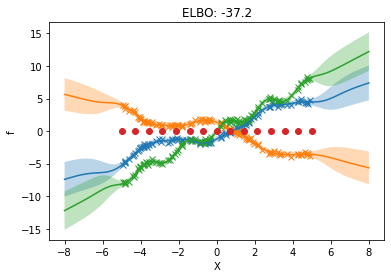

In [16]:
plot_model(m)

In [17]:
[k.kernels[0].lengthscales for k in m.kernel.kernels]

[<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9345562917197887>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9691707836072135>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7490186977810364>]

### 3. Separate independent kernel and separate independent inducing variables
Here we allow different hyperparameters for the priors of each output. We now allow different inducing inputs for each output.

In [18]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

**NOTE:** While the inducing points are independent, there needs to be the same number of inducing points per dimension.

In [19]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [20]:
optimize_model_with_scipy(m)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          460     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26251D+03    |proj g|=  1.79322D+03

At iterate    1    f=  1.42015D+03    |proj g|=  6.05642D+02

At iterate    2    f=  8.19726D+02    |proj g|=  3.33030D+02

At iterate    3    f=  5.14305D+02    |proj g|=  4.54513D+01

At iterate    4    f=  4.98859D+02    |proj g|=  2.70375D+01

At iterate    5    f=  4.92883D+02    |proj g|=  1.65439D+01

At iterate    6    f=  4.47787D+02    |proj g|=  5.59425D+01

At iterate    7    f=  4.25283D+02    |proj g|=  5.59362D+01

At iterate    8    f=  3.85436D+02    |proj g|=  5.49028D+01

At iterate    9    f=  3.67002D+02    |proj g|=  1.40400D+02

At iterate   10    f=  3.55533D+02    |proj g|=  5.48684D+01

At iterate   11    f=  3.39389D+02    |proj g|=  5.87781D+01

At iterate   12    f=  3.06578D+02    |proj g|=  8.56421D+01

At iterate   13    f=  2.8


At iterate   50    f=  1.91729D+02    |proj g|=  6.27078D+00

At iterate   51    f=  1.91546D+02    |proj g|=  5.44624D+00

At iterate   52    f=  1.91019D+02    |proj g|=  1.87534D+01

At iterate   53    f=  1.90482D+02    |proj g|=  2.07433D+01

At iterate   54    f=  1.89960D+02    |proj g|=  1.71691D+01

At iterate   55    f=  1.89637D+02    |proj g|=  3.45752D+01

At iterate   56    f=  1.89363D+02    |proj g|=  7.31923D+00

At iterate   57    f=  1.89268D+02    |proj g|=  7.01778D+00

At iterate   58    f=  1.88772D+02    |proj g|=  2.32259D+01

At iterate   59    f=  1.88433D+02    |proj g|=  3.14501D+01

At iterate   60    f=  1.87977D+02    |proj g|=  1.64249D+01

At iterate   61    f=  1.87555D+02    |proj g|=  1.20615D+01

At iterate   62    f=  1.87281D+02    |proj g|=  1.43445D+01

At iterate   63    f=  1.86985D+02    |proj g|=  2.82445D+01

At iterate   64    f=  1.86826D+02    |proj g|=  1.62064D+01

At iterate   65    f=  1.86707D+02    |proj g|=  5.64029D+00

At iter


At iterate  110    f=  8.12985D+01    |proj g|=  3.85449D+01

At iterate  111    f=  7.97539D+01    |proj g|=  1.21798D+02

At iterate  112    f=  7.78389D+01    |proj g|=  2.76056D+01

At iterate  113    f=  7.70760D+01    |proj g|=  1.72332D+01

At iterate  114    f=  7.63632D+01    |proj g|=  3.51017D+01

At iterate  115    f=  7.47666D+01    |proj g|=  4.22569D+01

At iterate  116    f=  7.27816D+01    |proj g|=  1.31850D+02

At iterate  117    f=  6.96590D+01    |proj g|=  6.21857D+01

At iterate  118    f=  6.75859D+01    |proj g|=  2.37336D+01

At iterate  119    f=  6.68851D+01    |proj g|=  5.60836D+01

At iterate  120    f=  6.62441D+01    |proj g|=  2.91285D+01

At iterate  121    f=  6.54839D+01    |proj g|=  4.06594D+01

At iterate  122    f=  6.39064D+01    |proj g|=  5.53832D+01

At iterate  123    f=  6.32193D+01    |proj g|=  1.14975D+02

At iterate  124    f=  6.18795D+01    |proj g|=  3.79867D+01

At iterate  125    f=  6.12657D+01    |proj g|=  1.90391D+01

At iter


At iterate  169    f=  4.92618D+01    |proj g|=  1.37075D+01

At iterate  170    f=  4.91836D+01    |proj g|=  1.59443D+01

At iterate  171    f=  4.90684D+01    |proj g|=  1.41733D+01

At iterate  172    f=  4.89600D+01    |proj g|=  3.87856D+01

At iterate  173    f=  4.88085D+01    |proj g|=  1.55984D+01

At iterate  174    f=  4.87086D+01    |proj g|=  1.39400D+01

At iterate  175    f=  4.85878D+01    |proj g|=  1.11147D+01

At iterate  176    f=  4.84316D+01    |proj g|=  2.34724D+01

At iterate  177    f=  4.83518D+01    |proj g|=  1.70073D+01

At iterate  178    f=  4.82768D+01    |proj g|=  8.02514D+00

At iterate  179    f=  4.82292D+01    |proj g|=  7.83294D+00

At iterate  180    f=  4.81225D+01    |proj g|=  1.13006D+01

At iterate  181    f=  4.79109D+01    |proj g|=  2.42711D+01

At iterate  182    f=  4.78240D+01    |proj g|=  3.34291D+01

At iterate  183    f=  4.77218D+01    |proj g|=  1.06940D+01

At iterate  184    f=  4.76909D+01    |proj g|=  5.20305D+00

At iter


At iterate  223    f=  4.52144D+01    |proj g|=  8.31115D+00

At iterate  224    f=  4.51799D+01    |proj g|=  4.64290D+00

At iterate  225    f=  4.51451D+01    |proj g|=  7.57386D+00

At iterate  226    f=  4.51025D+01    |proj g|=  1.25463D+01

At iterate  227    f=  4.50803D+01    |proj g|=  2.19296D+01

At iterate  228    f=  4.50189D+01    |proj g|=  8.68120D+00

At iterate  229    f=  4.49761D+01    |proj g|=  9.08202D+00

At iterate  230    f=  4.49154D+01    |proj g|=  1.16383D+01

At iterate  231    f=  4.48947D+01    |proj g|=  2.51330D+01

At iterate  232    f=  4.48469D+01    |proj g|=  1.21811D+01

At iterate  233    f=  4.48013D+01    |proj g|=  4.95923D+00

At iterate  234    f=  4.47663D+01    |proj g|=  1.94057D+01

At iterate  235    f=  4.47253D+01    |proj g|=  1.62368D+01

At iterate  236    f=  4.46454D+01    |proj g|=  1.27188D+01

At iterate  237    f=  4.46099D+01    |proj g|=  1.78449D+01

At iterate  238    f=  4.45659D+01    |proj g|=  5.55550D+00

At iter


At iterate  274    f=  4.33700D+01    |proj g|=  9.92881D+00

At iterate  275    f=  4.33591D+01    |proj g|=  1.31342D+01

At iterate  276    f=  4.33389D+01    |proj g|=  4.36982D+00

At iterate  277    f=  4.33224D+01    |proj g|=  5.20607D+00

At iterate  278    f=  4.32961D+01    |proj g|=  8.57276D+00

At iterate  279    f=  4.32535D+01    |proj g|=  1.13490D+01

At iterate  280    f=  4.32342D+01    |proj g|=  1.69935D+01

At iterate  281    f=  4.32038D+01    |proj g|=  5.82769D+00

At iterate  282    f=  4.31882D+01    |proj g|=  6.12792D+00

At iterate  283    f=  4.31660D+01    |proj g|=  6.85623D+00

At iterate  284    f=  4.31386D+01    |proj g|=  1.10232D+01

At iterate  285    f=  4.30983D+01    |proj g|=  1.80018D+01

At iterate  286    f=  4.30707D+01    |proj g|=  6.23275D+00

At iterate  287    f=  4.30578D+01    |proj g|=  4.19298D+00

At iterate  288    f=  4.30416D+01    |proj g|=  6.29086D+00

At iterate  289    f=  4.30204D+01    |proj g|=  7.38421D+00

At iter


At iterate  325    f=  4.20165D+01    |proj g|=  7.39411D+00

At iterate  326    f=  4.19900D+01    |proj g|=  1.28170D+01

At iterate  327    f=  4.19763D+01    |proj g|=  1.99871D+01

At iterate  328    f=  4.19562D+01    |proj g|=  7.73293D+00

At iterate  329    f=  4.19448D+01    |proj g|=  7.65876D+00

At iterate  330    f=  4.19272D+01    |proj g|=  9.78197D+00

At iterate  331    f=  4.19022D+01    |proj g|=  1.42288D+01

At iterate  332    f=  4.18566D+01    |proj g|=  1.53910D+01

At iterate  333    f=  4.18422D+01    |proj g|=  3.24855D+01

At iterate  334    f=  4.17643D+01    |proj g|=  8.82908D+00

At iterate  335    f=  4.17346D+01    |proj g|=  4.72058D+00

At iterate  336    f=  4.17067D+01    |proj g|=  9.38620D+00

At iterate  337    f=  4.16754D+01    |proj g|=  1.17045D+01

At iterate  338    f=  4.16348D+01    |proj g|=  2.06952D+01

At iterate  339    f=  4.16061D+01    |proj g|=  2.70595D+01

At iterate  340    f=  4.15732D+01    |proj g|=  1.03247D+01

At iter


At iterate  381    f=  4.01272D+01    |proj g|=  8.35396D+00

At iterate  382    f=  4.01151D+01    |proj g|=  1.29882D+01

At iterate  383    f=  4.00987D+01    |proj g|=  7.81196D+00

At iterate  384    f=  4.00533D+01    |proj g|=  4.49895D+00

At iterate  385    f=  4.00212D+01    |proj g|=  1.14316D+01

At iterate  386    f=  3.99878D+01    |proj g|=  4.81669D+00

At iterate  387    f=  3.99560D+01    |proj g|=  1.24246D+01

At iterate  388    f=  3.99395D+01    |proj g|=  2.89150D+01

At iterate  389    f=  3.99102D+01    |proj g|=  4.69294D+00

At iterate  390    f=  3.98978D+01    |proj g|=  5.97251D+00

At iterate  391    f=  3.98785D+01    |proj g|=  1.01880D+01

At iterate  392    f=  3.98489D+01    |proj g|=  1.17278D+01

At iterate  393    f=  3.98323D+01    |proj g|=  1.30596D+01

At iterate  394    f=  3.98123D+01    |proj g|=  5.74427D+00

At iterate  395    f=  3.97921D+01    |proj g|=  7.21124D+00

At iterate  396    f=  3.97759D+01    |proj g|=  2.08507D+01

At iter

At iterate  433    f=  3.89607D+01    |proj g|=  3.18600D+01

At iterate  434    f=  3.89361D+01    |proj g|=  3.42342D+00

At iterate  435    f=  3.89297D+01    |proj g|=  3.93499D+00

At iterate  436    f=  3.89132D+01    |proj g|=  1.04894D+01

At iterate  437    f=  3.88876D+01    |proj g|=  1.23254D+01

At iterate  438    f=  3.88724D+01    |proj g|=  2.21173D+01

At iterate  439    f=  3.88417D+01    |proj g|=  1.00489D+01

At iterate  440    f=  3.88195D+01    |proj g|=  3.62522D+00

At iterate  441    f=  3.88032D+01    |proj g|=  1.04391D+01

At iterate  442    f=  3.87913D+01    |proj g|=  1.15565D+01

At iterate  443    f=  3.87796D+01    |proj g|=  5.00117D+00

At iterate  444    f=  3.87691D+01    |proj g|=  4.23907D+00

At iterate  445    f=  3.87538D+01    |proj g|=  7.66769D+00

At iterate  446    f=  3.87324D+01    |proj g|=  7.93962D+00

At iterate  447    f=  3.87136D+01    |proj g|=  1.41370D+01

At iterate  448    f=  3.86933D+01    |proj g|=  3.63461D+00

At itera


At iterate  488    f=  3.83013D+01    |proj g|=  7.18208D+00

At iterate  489    f=  3.82942D+01    |proj g|=  3.09449D+00

At iterate  490    f=  3.82872D+01    |proj g|=  4.93003D+00

At iterate  491    f=  3.82773D+01    |proj g|=  7.68665D+00

At iterate  492    f=  3.82642D+01    |proj g|=  6.34609D+00

At iterate  493    f=  3.82542D+01    |proj g|=  8.85441D+00

At iterate  494    f=  3.82462D+01    |proj g|=  6.35870D+00

At iterate  495    f=  3.82368D+01    |proj g|=  8.74488D+00

At iterate  496    f=  3.82318D+01    |proj g|=  6.73852D+00

At iterate  497    f=  3.82271D+01    |proj g|=  3.97399D+00

At iterate  498    f=  3.82214D+01    |proj g|=  3.23471D+00

At iterate  499    f=  3.82135D+01    |proj g|=  4.14229D+00

At iterate  500    f=  3.82083D+01    |proj g|=  8.27644D+00

At iterate  501    f=  3.82018D+01    |proj g|=  4.22340D+00

At iterate  502    f=  3.81969D+01    |proj g|=  1.63814D+00

At iterate  503    f=  3.81919D+01    |proj g|=  2.97634D+00

At iter

At iterate  544    f=  3.80018D+01    |proj g|=  2.00267D+00

At iterate  545    f=  3.79974D+01    |proj g|=  1.44706D+00

At iterate  546    f=  3.79955D+01    |proj g|=  4.07019D+00

At iterate  547    f=  3.79922D+01    |proj g|=  2.83140D+00

At iterate  548    f=  3.79882D+01    |proj g|=  8.39540D+00

At iterate  549    f=  3.79837D+01    |proj g|=  2.64073D+00

At iterate  550    f=  3.79813D+01    |proj g|=  2.30434D+00

At iterate  551    f=  3.79727D+01    |proj g|=  3.55655D+00

At iterate  552    f=  3.79699D+01    |proj g|=  3.68868D+00

At iterate  553    f=  3.79671D+01    |proj g|=  1.36009D+00

At iterate  554    f=  3.79646D+01    |proj g|=  1.87235D+00

At iterate  555    f=  3.79615D+01    |proj g|=  3.56865D+00

At iterate  556    f=  3.79588D+01    |proj g|=  8.97877D+00

At iterate  557    f=  3.79557D+01    |proj g|=  2.85023D+00

At iterate  558    f=  3.79527D+01    |proj g|=  2.62439D+00

At iterate  559    f=  3.79512D+01    |proj g|=  2.55471D+00

At itera

At iterate  600    f=  3.78520D+01    |proj g|=  1.64725D+00

At iterate  601    f=  3.78495D+01    |proj g|=  3.39399D+00

At iterate  602    f=  3.78464D+01    |proj g|=  3.07264D+00

At iterate  603    f=  3.78448D+01    |proj g|=  3.24178D+00

At iterate  604    f=  3.78428D+01    |proj g|=  1.27605D+00

At iterate  605    f=  3.78414D+01    |proj g|=  2.18080D+00

At iterate  606    f=  3.78393D+01    |proj g|=  3.13574D+00

At iterate  607    f=  3.78362D+01    |proj g|=  4.71062D+00

At iterate  608    f=  3.78356D+01    |proj g|=  9.61620D+00

At iterate  609    f=  3.78328D+01    |proj g|=  1.04201D+00

At iterate  610    f=  3.78319D+01    |proj g|=  1.88851D+00

At iterate  611    f=  3.78301D+01    |proj g|=  3.88403D+00

At iterate  612    f=  3.78270D+01    |proj g|=  5.69674D+00

At iterate  613    f=  3.78257D+01    |proj g|=  4.57671D+00

At iterate  614    f=  3.78237D+01    |proj g|=  1.23598D+00

At iterate  615    f=  3.78224D+01    |proj g|=  1.01703D+00

At itera


At iterate  658    f=  3.77439D+01    |proj g|=  7.38678D+00

At iterate  659    f=  3.77411D+01    |proj g|=  2.23965D+00

At iterate  660    f=  3.77393D+01    |proj g|=  1.67082D+00

At iterate  661    f=  3.77379D+01    |proj g|=  3.51759D+00

At iterate  662    f=  3.77365D+01    |proj g|=  2.65160D+00

At iterate  663    f=  3.77335D+01    |proj g|=  3.53142D+00

At iterate  664    f=  3.77330D+01    |proj g|=  7.37067D+00

At iterate  665    f=  3.77300D+01    |proj g|=  1.45265D+00

At iterate  666    f=  3.77289D+01    |proj g|=  1.11692D+00

At iterate  667    f=  3.77270D+01    |proj g|=  2.21249D+00

At iterate  668    f=  3.77262D+01    |proj g|=  1.15511D+01

At iterate  669    f=  3.77227D+01    |proj g|=  2.74650D+00

At iterate  670    f=  3.77210D+01    |proj g|=  1.45094D+00

At iterate  671    f=  3.77193D+01    |proj g|=  2.37480D+00

At iterate  672    f=  3.77169D+01    |proj g|=  3.92763D+00

At iterate  673    f=  3.77153D+01    |proj g|=  7.10756D+00

At iter


At iterate  717    f=  3.76115D+01    |proj g|=  1.73568D+00

At iterate  718    f=  3.76095D+01    |proj g|=  3.01146D+00

At iterate  719    f=  3.76070D+01    |proj g|=  3.67864D+00

At iterate  720    f=  3.76028D+01    |proj g|=  2.95495D+00

At iterate  721    f=  3.76008D+01    |proj g|=  5.99974D+00

At iterate  722    f=  3.75975D+01    |proj g|=  1.54696D+00

At iterate  723    f=  3.75954D+01    |proj g|=  2.76186D+00

At iterate  724    f=  3.75929D+01    |proj g|=  2.51801D+00

At iterate  725    f=  3.75925D+01    |proj g|=  8.62077D+00

At iterate  726    f=  3.75884D+01    |proj g|=  2.51134D+00

At iterate  727    f=  3.75868D+01    |proj g|=  1.64026D+00

At iterate  728    f=  3.75851D+01    |proj g|=  2.88840D+00

At iterate  729    f=  3.75830D+01    |proj g|=  5.15062D+00

At iterate  730    f=  3.75807D+01    |proj g|=  8.99154D+00

At iterate  731    f=  3.75768D+01    |proj g|=  1.12884D+00

At iterate  732    f=  3.75749D+01    |proj g|=  1.47066D+00

At iter


At iterate  769    f=  3.74845D+01    |proj g|=  8.16204D+00

At iterate  770    f=  3.74800D+01    |proj g|=  4.04002D+00

At iterate  771    f=  3.74766D+01    |proj g|=  1.74709D+00

At iterate  772    f=  3.74749D+01    |proj g|=  4.86775D+00

At iterate  773    f=  3.74732D+01    |proj g|=  3.27888D+00

At iterate  774    f=  3.74708D+01    |proj g|=  4.36079D+00

At iterate  775    f=  3.74674D+01    |proj g|=  4.77114D+00

At iterate  776    f=  3.74653D+01    |proj g|=  4.41185D+00

At iterate  777    f=  3.74630D+01    |proj g|=  2.67890D+00

At iterate  778    f=  3.74604D+01    |proj g|=  2.82830D+00

At iterate  779    f=  3.74571D+01    |proj g|=  5.85127D+00

At iterate  780    f=  3.74542D+01    |proj g|=  5.25395D+00

At iterate  781    f=  3.74512D+01    |proj g|=  1.97919D+00

At iterate  782    f=  3.74488D+01    |proj g|=  2.03851D+00

At iterate  783    f=  3.74451D+01    |proj g|=  2.94851D+00

At iterate  784    f=  3.74387D+01    |proj g|=  6.48612D+00

At iter


At iterate  830    f=  3.73172D+01    |proj g|=  3.67448D+00

At iterate  831    f=  3.73160D+01    |proj g|=  1.51952D+00

At iterate  832    f=  3.73141D+01    |proj g|=  2.37265D+00

At iterate  833    f=  3.73118D+01    |proj g|=  3.88308D+00

At iterate  834    f=  3.73089D+01    |proj g|=  3.25803D+00

At iterate  835    f=  3.73060D+01    |proj g|=  9.04252D+00

At iterate  836    f=  3.73029D+01    |proj g|=  5.83096D+00

At iterate  837    f=  3.73012D+01    |proj g|=  2.08483D+00

At iterate  838    f=  3.73002D+01    |proj g|=  1.72232D+00

At iterate  839    f=  3.72987D+01    |proj g|=  2.39551D+00

At iterate  840    f=  3.72954D+01    |proj g|=  2.93192D+00

At iterate  841    f=  3.72917D+01    |proj g|=  4.34812D+00

At iterate  842    f=  3.72904D+01    |proj g|=  5.57192D+00

At iterate  843    f=  3.72888D+01    |proj g|=  8.17508D-01

At iterate  844    f=  3.72877D+01    |proj g|=  2.01470D+00

At iterate  845    f=  3.72859D+01    |proj g|=  3.88939D+00

At iter


At iterate  895    f=  3.72127D+01    |proj g|=  1.62500D+00

At iterate  896    f=  3.72117D+01    |proj g|=  2.83843D+00

At iterate  897    f=  3.72106D+01    |proj g|=  2.94942D+00

At iterate  898    f=  3.72093D+01    |proj g|=  6.02985D+00

At iterate  899    f=  3.72077D+01    |proj g|=  1.49076D+00

At iterate  900    f=  3.72072D+01    |proj g|=  9.31803D-01

At iterate  901    f=  3.72067D+01    |proj g|=  1.43249D+00

At iterate  902    f=  3.72062D+01    |proj g|=  5.68897D+00

At iterate  903    f=  3.72053D+01    |proj g|=  3.19218D+00

At iterate  904    f=  3.72038D+01    |proj g|=  1.53179D+00

At iterate  905    f=  3.72033D+01    |proj g|=  1.42790D+00

At iterate  906    f=  3.72014D+01    |proj g|=  4.43784D+00

At iterate  907    f=  3.71994D+01    |proj g|=  3.28051D+00

At iterate  908    f=  3.71986D+01    |proj g|=  2.33064D+00

At iterate  909    f=  3.71981D+01    |proj g|=  7.66209D-01

At iterate  910    f=  3.71976D+01    |proj g|=  1.58051D+00

At iter


At iterate  958    f=  3.71497D+01    |proj g|=  1.48069D+00

At iterate  959    f=  3.71490D+01    |proj g|=  1.74453D+00

At iterate  960    f=  3.71480D+01    |proj g|=  6.17704D+00

At iterate  961    f=  3.71467D+01    |proj g|=  2.72742D+00

At iterate  962    f=  3.71454D+01    |proj g|=  1.16479D+00

At iterate  963    f=  3.71448D+01    |proj g|=  2.47569D+00

At iterate  964    f=  3.71438D+01    |proj g|=  1.28804D+00

At iterate  965    f=  3.71426D+01    |proj g|=  1.12765D+00

At iterate  966    f=  3.71419D+01    |proj g|=  5.07982D+00

At iterate  967    f=  3.71402D+01    |proj g|=  1.47969D+00

At iterate  968    f=  3.71397D+01    |proj g|=  1.00228D+00

At iterate  969    f=  3.71389D+01    |proj g|=  1.40948D+00

At iterate  970    f=  3.71385D+01    |proj g|=  2.83500D+00

At iterate  971    f=  3.71376D+01    |proj g|=  1.82277D+00

At iterate  972    f=  3.71369D+01    |proj g|=  9.85482D-01

At iterate  973    f=  3.71364D+01    |proj g|=  4.21939D+00

At iter


At iterate 1023    f=  3.70881D+01    |proj g|=  9.25744D-01

At iterate 1024    f=  3.70872D+01    |proj g|=  1.94265D+00

At iterate 1025    f=  3.70859D+01    |proj g|=  2.86364D+00

At iterate 1026    f=  3.70851D+01    |proj g|=  3.27861D+00

At iterate 1027    f=  3.70842D+01    |proj g|=  8.85391D-01

At iterate 1028    f=  3.70835D+01    |proj g|=  1.99303D+00

At iterate 1029    f=  3.70827D+01    |proj g|=  1.85602D+00

At iterate 1030    f=  3.70824D+01    |proj g|=  3.65634D+00

At iterate 1031    f=  3.70816D+01    |proj g|=  1.78842D+00

At iterate 1032    f=  3.70807D+01    |proj g|=  6.25302D-01

At iterate 1033    f=  3.70800D+01    |proj g|=  4.39994D+00

At iterate 1034    f=  3.70793D+01    |proj g|=  1.77140D+00

At iterate 1035    f=  3.70786D+01    |proj g|=  8.51578D-01

At iterate 1036    f=  3.70779D+01    |proj g|=  1.52910D+00

At iterate 1037    f=  3.70773D+01    |proj g|=  9.49322D-01

At iterate 1038    f=  3.70766D+01    |proj g|=  1.19763D+00

At iter


At iterate 1084    f=  3.70400D+01    |proj g|=  7.05262D-01

At iterate 1085    f=  3.70395D+01    |proj g|=  7.96417D-01

At iterate 1086    f=  3.70390D+01    |proj g|=  2.11953D+00

At iterate 1087    f=  3.70382D+01    |proj g|=  1.14228D+00

At iterate 1088    f=  3.70374D+01    |proj g|=  2.28981D+00

At iterate 1089    f=  3.70370D+01    |proj g|=  2.66250D+00

At iterate 1090    f=  3.70367D+01    |proj g|=  7.86616D-01

At iterate 1091    f=  3.70363D+01    |proj g|=  6.99277D-01

At iterate 1092    f=  3.70356D+01    |proj g|=  2.59349D+00

At iterate 1093    f=  3.70347D+01    |proj g|=  3.27400D+00

At iterate 1094    f=  3.70342D+01    |proj g|=  3.85316D+00

At iterate 1095    f=  3.70337D+01    |proj g|=  1.31304D+00

At iterate 1096    f=  3.70334D+01    |proj g|=  1.06340D+00

At iterate 1097    f=  3.70331D+01    |proj g|=  2.03721D+00

At iterate 1098    f=  3.70324D+01    |proj g|=  3.06400D+00

At iterate 1099    f=  3.70315D+01    |proj g|=  2.87062D+00

At iter


At iterate 1147    f=  3.70069D+01    |proj g|=  3.61592D+00

At iterate 1148    f=  3.70065D+01    |proj g|=  1.23324D+00

At iterate 1149    f=  3.70061D+01    |proj g|=  9.80210D-01

At iterate 1150    f=  3.70056D+01    |proj g|=  1.69484D+00

At iterate 1151    f=  3.70051D+01    |proj g|=  2.14862D+00

At iterate 1152    f=  3.70044D+01    |proj g|=  2.10128D+00

At iterate 1153    f=  3.70037D+01    |proj g|=  1.23899D+00

At iterate 1154    f=  3.70028D+01    |proj g|=  1.70046D+00

At iterate 1155    f=  3.70024D+01    |proj g|=  9.56055D-01

At iterate 1156    f=  3.70020D+01    |proj g|=  7.52119D-01

At iterate 1157    f=  3.70018D+01    |proj g|=  8.99211D-01

At iterate 1158    f=  3.70014D+01    |proj g|=  2.44141D+00

At iterate 1159    f=  3.70010D+01    |proj g|=  1.13233D+00

At iterate 1160    f=  3.70006D+01    |proj g|=  9.61470D-01

At iterate 1161    f=  3.70002D+01    |proj g|=  1.08438D+00

At iterate 1162    f=  3.69997D+01    |proj g|=  1.19324D+00

At iter


At iterate 1214    f=  3.69857D+01    |proj g|=  6.30385D-01

At iterate 1215    f=  3.69856D+01    |proj g|=  1.91623D+00

At iterate 1216    f=  3.69853D+01    |proj g|=  1.47366D+00

At iterate 1217    f=  3.69849D+01    |proj g|=  6.03395D-01

At iterate 1218    f=  3.69847D+01    |proj g|=  1.85838D+00

At iterate 1219    f=  3.69845D+01    |proj g|=  4.83203D-01

At iterate 1220    f=  3.69844D+01    |proj g|=  6.63814D-01

At iterate 1221    f=  3.69842D+01    |proj g|=  2.14741D+00

At iterate 1222    f=  3.69839D+01    |proj g|=  1.94544D+00

At iterate 1223    f=  3.69835D+01    |proj g|=  1.10329D+00

At iterate 1224    f=  3.69832D+01    |proj g|=  4.96351D-01

At iterate 1225    f=  3.69830D+01    |proj g|=  1.14627D+00

At iterate 1226    f=  3.69827D+01    |proj g|=  1.43656D+00

At iterate 1227    f=  3.69826D+01    |proj g|=  2.69076D+00

At iterate 1228    f=  3.69822D+01    |proj g|=  5.81218D-01

At iterate 1229    f=  3.69821D+01    |proj g|=  4.13328D-01

At iter

At iterate 1281    f=  3.69749D+01    |proj g|=  5.68786D-01

At iterate 1282    f=  3.69747D+01    |proj g|=  4.93404D-01

At iterate 1283    f=  3.69747D+01    |proj g|=  5.84374D-01

At iterate 1284    f=  3.69745D+01    |proj g|=  6.04660D-01

At iterate 1285    f=  3.69744D+01    |proj g|=  9.35928D-01

At iterate 1286    f=  3.69743D+01    |proj g|=  5.00400D-01

At iterate 1287    f=  3.69742D+01    |proj g|=  8.22082D-01

At iterate 1288    f=  3.69741D+01    |proj g|=  2.27895D+00

At iterate 1289    f=  3.69740D+01    |proj g|=  6.61960D-01

At iterate 1290    f=  3.69739D+01    |proj g|=  3.41520D-01

At iterate 1291    f=  3.69739D+01    |proj g|=  5.96260D-01

At iterate 1292    f=  3.69738D+01    |proj g|=  6.25378D-01

At iterate 1293    f=  3.69737D+01    |proj g|=  1.95590D+00

At iterate 1294    f=  3.69736D+01    |proj g|=  3.87495D-01

At iterate 1295    f=  3.69735D+01    |proj g|=  4.33564D-01

At iterate 1296    f=  3.69733D+01    |proj g|=  6.95439D-01

At itera

At iterate 1349    f=  3.69699D+01    |proj g|=  8.47711D-01

At iterate 1350    f=  3.69698D+01    |proj g|=  1.70393D+00

At iterate 1351    f=  3.69697D+01    |proj g|=  1.81214D-01

At iterate 1352    f=  3.69697D+01    |proj g|=  3.11230D-01

At iterate 1353    f=  3.69696D+01    |proj g|=  5.34873D-01

At iterate 1354    f=  3.69695D+01    |proj g|=  8.17866D-01

At iterate 1355    f=  3.69695D+01    |proj g|=  2.20518D+00

At iterate 1356    f=  3.69694D+01    |proj g|=  3.78521D-01

At iterate 1357    f=  3.69693D+01    |proj g|=  4.46505D-01

At iterate 1358    f=  3.69693D+01    |proj g|=  2.32570D-01

At iterate 1359    f=  3.69692D+01    |proj g|=  9.62898D-01

At iterate 1360    f=  3.69691D+01    |proj g|=  4.77819D-01

At iterate 1361    f=  3.69691D+01    |proj g|=  4.39587D-01

At iterate 1362    f=  3.69690D+01    |proj g|=  1.00245D+00

At iterate 1363    f=  3.69690D+01    |proj g|=  8.77086D-01

At iterate 1364    f=  3.69689D+01    |proj g|=  2.65414D-01

At itera


At iterate 1412    f=  3.69658D+01    |proj g|=  6.09617D-01

At iterate 1413    f=  3.69657D+01    |proj g|=  3.37501D-01

At iterate 1414    f=  3.69657D+01    |proj g|=  2.31854D-01

At iterate 1415    f=  3.69656D+01    |proj g|=  8.21570D-01

At iterate 1416    f=  3.69656D+01    |proj g|=  2.92716D-01

At iterate 1417    f=  3.69655D+01    |proj g|=  4.15610D-01

At iterate 1418    f=  3.69654D+01    |proj g|=  7.53128D-01

At iterate 1419    f=  3.69653D+01    |proj g|=  8.27874D-01

At iterate 1420    f=  3.69653D+01    |proj g|=  7.87083D-01

At iterate 1421    f=  3.69652D+01    |proj g|=  1.41166D-01

At iterate 1422    f=  3.69652D+01    |proj g|=  3.60083D-01

At iterate 1423    f=  3.69652D+01    |proj g|=  5.27215D-01

At iterate 1424    f=  3.69650D+01    |proj g|=  1.02357D+00

At iterate 1425    f=  3.69650D+01    |proj g|=  8.17536D-01

At iterate 1426    f=  3.69649D+01    |proj g|=  4.06906D-01

At iterate 1427    f=  3.69648D+01    |proj g|=  6.10538D-01

At iter


At iterate 1469    f=  3.69623D+01    |proj g|=  5.59869D-01

At iterate 1470    f=  3.69622D+01    |proj g|=  8.75935D-01

At iterate 1471    f=  3.69621D+01    |proj g|=  5.16764D-01

At iterate 1472    f=  3.69620D+01    |proj g|=  1.00708D+00

At iterate 1473    f=  3.69619D+01    |proj g|=  3.57129D-01

At iterate 1474    f=  3.69618D+01    |proj g|=  3.42181D-01

At iterate 1475    f=  3.69617D+01    |proj g|=  8.32463D-01

At iterate 1476    f=  3.69616D+01    |proj g|=  1.15266D+00

At iterate 1477    f=  3.69615D+01    |proj g|=  4.77509D-01

At iterate 1478    f=  3.69615D+01    |proj g|=  1.81375D-01

At iterate 1479    f=  3.69615D+01    |proj g|=  2.41751D-01

At iterate 1480    f=  3.69614D+01    |proj g|=  6.80532D-01

At iterate 1481    f=  3.69613D+01    |proj g|=  6.72127D-01

At iterate 1482    f=  3.69612D+01    |proj g|=  1.25157D+00

At iterate 1483    f=  3.69612D+01    |proj g|=  2.90893D-01

At iterate 1484    f=  3.69611D+01    |proj g|=  3.59657D-01

At iter


At iterate 1531    f=  3.69579D+01    |proj g|=  1.62590D+00

At iterate 1532    f=  3.69578D+01    |proj g|=  3.57514D-01

At iterate 1533    f=  3.69577D+01    |proj g|=  5.26618D-01

At iterate 1534    f=  3.69577D+01    |proj g|=  5.49459D-01

At iterate 1535    f=  3.69576D+01    |proj g|=  9.86919D-01

At iterate 1536    f=  3.69575D+01    |proj g|=  1.04982D+00

At iterate 1537    f=  3.69575D+01    |proj g|=  4.64459D-01

At iterate 1538    f=  3.69575D+01    |proj g|=  2.55863D-01

At iterate 1539    f=  3.69574D+01    |proj g|=  3.63836D-01

At iterate 1540    f=  3.69573D+01    |proj g|=  9.53883D-01

At iterate 1541    f=  3.69573D+01    |proj g|=  1.04620D+00

At iterate 1542    f=  3.69572D+01    |proj g|=  4.84896D-01

At iterate 1543    f=  3.69571D+01    |proj g|=  3.75554D-01

At iterate 1544    f=  3.69571D+01    |proj g|=  1.72897D+00

At iterate 1545    f=  3.69571D+01    |proj g|=  4.77847D-01

At iterate 1546    f=  3.69570D+01    |proj g|=  2.52316D-01

At iter


At iterate 1594    f=  3.69539D+01    |proj g|=  4.70100D-01

At iterate 1595    f=  3.69538D+01    |proj g|=  5.11702D-01

At iterate 1596    f=  3.69538D+01    |proj g|=  8.51375D-01

At iterate 1597    f=  3.69537D+01    |proj g|=  3.82589D-01

At iterate 1598    f=  3.69537D+01    |proj g|=  2.62168D-01

At iterate 1599    f=  3.69537D+01    |proj g|=  2.77515D-01

At iterate 1600    f=  3.69537D+01    |proj g|=  2.20867D-01

At iterate 1601    f=  3.69536D+01    |proj g|=  6.42580D-01

At iterate 1602    f=  3.69536D+01    |proj g|=  8.21030D-01

At iterate 1603    f=  3.69535D+01    |proj g|=  6.47945D-01

At iterate 1604    f=  3.69535D+01    |proj g|=  1.09657D+00

At iterate 1605    f=  3.69534D+01    |proj g|=  3.23813D-01

At iterate 1606    f=  3.69534D+01    |proj g|=  2.33283D-01

At iterate 1607    f=  3.69533D+01    |proj g|=  5.42843D-01

At iterate 1608    f=  3.69533D+01    |proj g|=  6.53615D-01

At iterate 1609    f=  3.69532D+01    |proj g|=  7.73808D-01

At iter


At iterate 1651    f=  3.69519D+01    |proj g|=  3.33036D-01

At iterate 1652    f=  3.69519D+01    |proj g|=  1.37769D-01

At iterate 1653    f=  3.69518D+01    |proj g|=  8.13975D-02

At iterate 1654    f=  3.69518D+01    |proj g|=  1.08672D+00

At iterate 1655    f=  3.69518D+01    |proj g|=  5.10736D-01

At iterate 1656    f=  3.69518D+01    |proj g|=  2.01083D-01

At iterate 1657    f=  3.69518D+01    |proj g|=  3.97557D-01

At iterate 1658    f=  3.69518D+01    |proj g|=  3.44742D-01

At iterate 1659    f=  3.69518D+01    |proj g|=  5.81419D-01

At iterate 1660    f=  3.69517D+01    |proj g|=  3.81484D-01

At iterate 1661    f=  3.69517D+01    |proj g|=  3.12157D-01

At iterate 1662    f=  3.69517D+01    |proj g|=  3.78548D-01

At iterate 1663    f=  3.69517D+01    |proj g|=  5.82406D-01

At iterate 1664    f=  3.69517D+01    |proj g|=  1.75455D-01

At iterate 1665    f=  3.69517D+01    |proj g|=  2.06932D-01

At iterate 1666    f=  3.69516D+01    |proj g|=  5.60466D-01

At iter


At iterate 1707    f=  3.69510D+01    |proj g|=  7.06749D-01

At iterate 1708    f=  3.69509D+01    |proj g|=  2.28062D-01

At iterate 1709    f=  3.69509D+01    |proj g|=  2.29366D-01

At iterate 1710    f=  3.69509D+01    |proj g|=  3.23453D-01

At iterate 1711    f=  3.69509D+01    |proj g|=  8.88665D-01

At iterate 1712    f=  3.69509D+01    |proj g|=  4.37542D-01

At iterate 1713    f=  3.69509D+01    |proj g|=  1.75211D-01

At iterate 1714    f=  3.69509D+01    |proj g|=  3.94139D-01

At iterate 1715    f=  3.69509D+01    |proj g|=  5.15910D-01

At iterate 1716    f=  3.69508D+01    |proj g|=  6.78261D-01

At iterate 1717    f=  3.69508D+01    |proj g|=  5.14051D-01

At iterate 1718    f=  3.69508D+01    |proj g|=  1.35966D-01

At iterate 1719    f=  3.69508D+01    |proj g|=  3.43123D-01

At iterate 1720    f=  3.69508D+01    |proj g|=  1.14842D+00

At iterate 1721    f=  3.69507D+01    |proj g|=  5.26125D-01

At iterate 1722    f=  3.69507D+01    |proj g|=  2.40473D-01

At iter


At iterate 1767    f=  3.69499D+01    |proj g|=  2.66237D-01

At iterate 1768    f=  3.69499D+01    |proj g|=  7.08417D-01

At iterate 1769    f=  3.69499D+01    |proj g|=  3.84535D-01

At iterate 1770    f=  3.69499D+01    |proj g|=  3.15109D-01

At iterate 1771    f=  3.69499D+01    |proj g|=  2.94200D-01

At iterate 1772    f=  3.69499D+01    |proj g|=  2.07940D-01

At iterate 1773    f=  3.69499D+01    |proj g|=  2.50800D-01

At iterate 1774    f=  3.69499D+01    |proj g|=  2.64743D-01

At iterate 1775    f=  3.69498D+01    |proj g|=  2.80870D-01

At iterate 1776    f=  3.69498D+01    |proj g|=  2.96334D-01

At iterate 1777    f=  3.69498D+01    |proj g|=  1.11082D-01

At iterate 1778    f=  3.69498D+01    |proj g|=  1.86291D-01

At iterate 1779    f=  3.69498D+01    |proj g|=  5.01538D-01

At iterate 1780    f=  3.69498D+01    |proj g|=  4.55590D-01

At iterate 1781    f=  3.69497D+01    |proj g|=  3.23279D-01

At iterate 1782    f=  3.69497D+01    |proj g|=  3.72616D-01

At iter


At iterate 1825    f=  3.69493D+01    |proj g|=  3.73613D-01

At iterate 1826    f=  3.69493D+01    |proj g|=  3.21927D-01

At iterate 1827    f=  3.69492D+01    |proj g|=  6.56440D-02

At iterate 1828    f=  3.69492D+01    |proj g|=  1.66491D-01

At iterate 1829    f=  3.69492D+01    |proj g|=  3.98590D-01

At iterate 1830    f=  3.69492D+01    |proj g|=  7.51629D-01

At iterate 1831    f=  3.69492D+01    |proj g|=  2.03988D-01

At iterate 1832    f=  3.69492D+01    |proj g|=  9.57804D-02

At iterate 1833    f=  3.69492D+01    |proj g|=  1.55882D-01

At iterate 1834    f=  3.69492D+01    |proj g|=  1.93696D-01

At iterate 1835    f=  3.69492D+01    |proj g|=  2.80111D-01

At iterate 1836    f=  3.69492D+01    |proj g|=  1.52623D-01

At iterate 1837    f=  3.69492D+01    |proj g|=  2.65784D-01

At iterate 1838    f=  3.69492D+01    |proj g|=  4.38640D-01

At iterate 1839    f=  3.69492D+01    |proj g|=  2.94839D-01

At iterate 1840    f=  3.69491D+01    |proj g|=  1.27132D-01

At iter


At iterate 1892    f=  3.69488D+01    |proj g|=  2.19672D-01

At iterate 1893    f=  3.69488D+01    |proj g|=  2.79020D-01

At iterate 1894    f=  3.69488D+01    |proj g|=  8.13098D-02

At iterate 1895    f=  3.69488D+01    |proj g|=  1.25376D-01

At iterate 1896    f=  3.69488D+01    |proj g|=  5.60374D-02

At iterate 1897    f=  3.69488D+01    |proj g|=  6.01486D-01

At iterate 1898    f=  3.69488D+01    |proj g|=  2.34435D-01

At iterate 1899    f=  3.69488D+01    |proj g|=  9.08828D-02

At iterate 1900    f=  3.69488D+01    |proj g|=  1.21988D-01

At iterate 1901    f=  3.69488D+01    |proj g|=  1.30590D-01

At iterate 1902    f=  3.69488D+01    |proj g|=  2.06417D-01

At iterate 1903    f=  3.69488D+01    |proj g|=  1.85785D-01

At iterate 1904    f=  3.69488D+01    |proj g|=  9.98994D-02

At iterate 1905    f=  3.69488D+01    |proj g|=  1.03880D-01

At iterate 1906    f=  3.69488D+01    |proj g|=  2.43452D-01

At iterate 1907    f=  3.69488D+01    |proj g|=  2.25395D-01

At iter

At iterate 1957    f=  3.69485D+01    |proj g|=  1.39622D-01

At iterate 1958    f=  3.69485D+01    |proj g|=  1.72756D-01

At iterate 1959    f=  3.69485D+01    |proj g|=  1.78865D-01

At iterate 1960    f=  3.69485D+01    |proj g|=  7.02207D-02

At iterate 1961    f=  3.69485D+01    |proj g|=  1.10608D-01

At iterate 1962    f=  3.69485D+01    |proj g|=  1.07967D-01

At iterate 1963    f=  3.69484D+01    |proj g|=  1.31845D-01

At iterate 1964    f=  3.69484D+01    |proj g|=  1.95785D-01

At iterate 1965    f=  3.69484D+01    |proj g|=  6.83258D-02

At iterate 1966    f=  3.69484D+01    |proj g|=  1.03340D-01

At iterate 1967    f=  3.69484D+01    |proj g|=  2.70566D-01

At iterate 1968    f=  3.69484D+01    |proj g|=  1.69769D-01

At iterate 1969    f=  3.69484D+01    |proj g|=  5.90189D-02

At iterate 1970    f=  3.69484D+01    |proj g|=  1.74311D-01

At iterate 1971    f=  3.69484D+01    |proj g|=  1.90571D-01

At iterate 1972    f=  3.69484D+01    |proj g|=  1.02720D-01

At itera

At iterate 2000    f=  3.69483D+01    |proj g|=  1.38681D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  460   2000   2138      1     0     0   1.387D-01   3.695D+01
  F =   36.948288281790319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


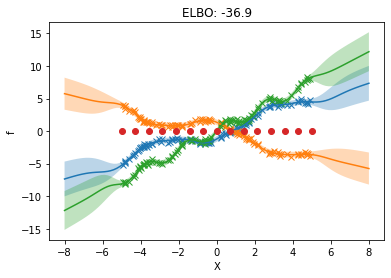

In [21]:
plot_model(m)

The following plot shows that we use different inducing *inputs* in each output dimension.

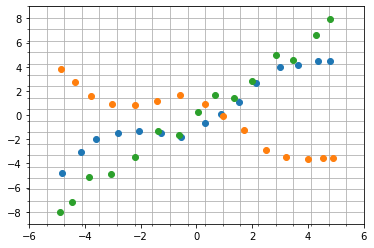

In [22]:
for i in range(len(m.inducing_variable.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variable.inducing_variable_list[i].Z)
    plt.plot(
        m.inducing_variable.inducing_variable_list[i].Z.numpy(),
        q_mu_unwhitened[:, i, None].numpy(),
        "o",
    )
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which="minor")

In [23]:
m.inducing_variable.inducing_variable_list

ListWrapper([<gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7f3ae064f550>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7f3ae064f890>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7f3ae064fd50>])

## Model $f(x)$ by doing inference in the $g$ space
### Mixed kernel and uncorrelated inducing variables

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W\Sigma_g W^\top$

- $K_{uu} = L \times M \times M$
- $K_{uf} = L \times M \times N$

In [24]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(L)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [25]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, q_mu=q_mu, q_sqrt=q_sqrt
)

In [26]:
optimize_model_with_scipy(m)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44521D+03    |proj g|=  6.62929D+03

At iterate    1    f=  2.36416D+03    |proj g|=  1.23564D+03

At iterate    2    f=  1.83455D+03    |proj g|=  7.22082D+02

At iterate    3    f=  1.34617D+03    |proj g|=  4.07037D+02

At iterate    4    f=  9.75596D+02    |proj g|=  2.74850D+02

At iterate    5    f=  6.91998D+02    |proj g|=  4.13533D+02

At iterate    6    f=  5.67713D+02    |proj g|=  3.53914D+02

At iterate    7    f=  5.49446D+02    |proj g|=  1.18558D+02

At iterate    8    f=  5.42303D+02    |proj g|=  9.66796D+01

At iterate    9    f=  5.32036D+02    |proj g|=  4.68484D+01

At iterate   10    f=  5.15816D+02    |proj g|=  7.92374D+01

At iterate   11    f=  5.14297D+02    |proj g|=  3.02286D+02

At iterate   12    f=  4.64147D+02    |proj g|=  9.53409D+01

At iterate   13    f=  4.4

 This problem is unconstrained.



At iterate   62    f=  3.12474D+02    |proj g|=  2.43427D+01

At iterate   63    f=  3.11960D+02    |proj g|=  1.42614D+01

At iterate   64    f=  3.11625D+02    |proj g|=  6.08413D+00

At iterate   65    f=  3.11317D+02    |proj g|=  8.60480D+00

At iterate   66    f=  3.10894D+02    |proj g|=  1.94939D+01

At iterate   67    f=  3.10210D+02    |proj g|=  6.18708D+01

At iterate   68    f=  3.09069D+02    |proj g|=  2.81195D+01

At iterate   69    f=  3.07932D+02    |proj g|=  1.72443D+01

At iterate   70    f=  3.07041D+02    |proj g|=  1.78789D+01

At iterate   71    f=  3.05399D+02    |proj g|=  2.09066D+01

At iterate   72    f=  3.03886D+02    |proj g|=  2.27979D+01

At iterate   73    f=  3.02733D+02    |proj g|=  1.73922D+01

At iterate   74    f=  3.01868D+02    |proj g|=  3.16635D+01

At iterate   75    f=  3.00976D+02    |proj g|=  3.24579D+01

At iterate   76    f=  2.99311D+02    |proj g|=  2.83720D+01

At iterate   77    f=  2.94117D+02    |proj g|=  8.28975D+01

At iter

At iterate  136    f=  1.36284D+02    |proj g|=  1.10716D+02

At iterate  137    f=  1.35209D+02    |proj g|=  5.20546D+01

At iterate  138    f=  1.34466D+02    |proj g|=  3.08711D+01

At iterate  139    f=  1.33564D+02    |proj g|=  5.41572D+01

At iterate  140    f=  1.31999D+02    |proj g|=  6.22093D+01

At iterate  141    f=  1.27734D+02    |proj g|=  1.37910D+02

At iterate  142    f=  1.26197D+02    |proj g|=  1.52251D+02

At iterate  143    f=  1.23935D+02    |proj g|=  4.88103D+01

At iterate  144    f=  1.22348D+02    |proj g|=  6.57958D+01

At iterate  145    f=  1.20617D+02    |proj g|=  8.57253D+01

At iterate  146    f=  1.17127D+02    |proj g|=  7.15158D+01

At iterate  147    f=  1.15066D+02    |proj g|=  5.18676D+01

At iterate  148    f=  1.12943D+02    |proj g|=  5.34543D+01

At iterate  149    f=  1.09169D+02    |proj g|=  1.83990D+02

At iterate  150    f=  1.06436D+02    |proj g|=  1.96245D+02

At iterate  151    f=  1.04955D+02    |proj g|=  1.66268D+02

At itera

At iterate  206    f=  3.34501D+01    |proj g|=  9.72637D+01

At iterate  207    f=  3.30546D+01    |proj g|=  5.23087D+01

At iterate  208    f=  3.24717D+01    |proj g|=  2.63212D+01

At iterate  209    f=  3.21549D+01    |proj g|=  2.08535D+01

At iterate  210    f=  3.20190D+01    |proj g|=  8.03010D+01

At iterate  211    f=  3.17576D+01    |proj g|=  3.84449D+01

At iterate  212    f=  3.14340D+01    |proj g|=  2.35505D+01

At iterate  213    f=  3.09349D+01    |proj g|=  4.20726D+01

At iterate  214    f=  3.03857D+01    |proj g|=  5.14845D+01

At iterate  215    f=  3.00198D+01    |proj g|=  6.27703D+01

At iterate  216    f=  2.95354D+01    |proj g|=  2.19704D+01

At iterate  217    f=  2.92089D+01    |proj g|=  2.63965D+01

At iterate  218    f=  2.91198D+01    |proj g|=  8.30222D+01

At iterate  219    f=  2.89561D+01    |proj g|=  5.66280D+01

At iterate  220    f=  2.86709D+01    |proj g|=  2.41453D+01

At iterate  221    f=  2.83608D+01    |proj g|=  2.86919D+01

At itera


At iterate  265    f=  2.01645D+01    |proj g|=  2.97397D+01

At iterate  266    f=  1.99561D+01    |proj g|=  3.67986D+01

At iterate  267    f=  1.98502D+01    |proj g|=  4.68468D+01

At iterate  268    f=  1.96991D+01    |proj g|=  1.12053D+01

At iterate  269    f=  1.96294D+01    |proj g|=  1.92133D+01

At iterate  270    f=  1.95589D+01    |proj g|=  6.64994D+01

At iterate  271    f=  1.94757D+01    |proj g|=  1.61206D+01

At iterate  272    f=  1.94021D+01    |proj g|=  1.67776D+01

At iterate  273    f=  1.93003D+01    |proj g|=  3.97632D+01

At iterate  274    f=  1.92165D+01    |proj g|=  2.32507D+01

At iterate  275    f=  1.91923D+01    |proj g|=  9.42429D+01

At iterate  276    f=  1.90813D+01    |proj g|=  1.61970D+01

At iterate  277    f=  1.90140D+01    |proj g|=  1.57449D+01

At iterate  278    f=  1.89199D+01    |proj g|=  2.95738D+01

At iterate  279    f=  1.88350D+01    |proj g|=  1.84604D+01

At iterate  280    f=  1.88216D+01    |proj g|=  4.35341D+01

At iter


At iterate  333    f=  1.41171D+01    |proj g|=  1.08525D+01

At iterate  334    f=  1.40462D+01    |proj g|=  2.27183D+01

At iterate  335    f=  1.40237D+01    |proj g|=  5.07039D+01

At iterate  336    f=  1.39663D+01    |proj g|=  2.68126D+01

At iterate  337    f=  1.39032D+01    |proj g|=  1.27903D+01

At iterate  338    f=  1.38467D+01    |proj g|=  1.58659D+01

At iterate  339    f=  1.37616D+01    |proj g|=  2.10562D+01

At iterate  340    f=  1.37074D+01    |proj g|=  5.57974D+01

At iterate  341    f=  1.35990D+01    |proj g|=  2.66991D+01

At iterate  342    f=  1.35292D+01    |proj g|=  8.33811D+00

At iterate  343    f=  1.34832D+01    |proj g|=  1.39580D+01

At iterate  344    f=  1.34297D+01    |proj g|=  2.52573D+01

At iterate  345    f=  1.33404D+01    |proj g|=  3.30591D+01

At iterate  346    f=  1.32426D+01    |proj g|=  1.57584D+01

At iterate  347    f=  1.31053D+01    |proj g|=  1.42540D+01

At iterate  348    f=  1.30887D+01    |proj g|=  6.48786D+01

At iter


At iterate  403    f=  9.50591D+00    |proj g|=  1.21367D+01

At iterate  404    f=  9.48560D+00    |proj g|=  1.00822D+01

At iterate  405    f=  9.44227D+00    |proj g|=  1.27519D+01

At iterate  406    f=  9.38045D+00    |proj g|=  8.88095D+00

At iterate  407    f=  9.35988D+00    |proj g|=  3.60294D+01

At iterate  408    f=  9.32786D+00    |proj g|=  1.57863D+01

At iterate  409    f=  9.30120D+00    |proj g|=  6.85500D+00

At iterate  410    f=  9.27985D+00    |proj g|=  1.11356D+01

At iterate  411    f=  9.22374D+00    |proj g|=  1.64684D+01

At iterate  412    f=  9.20116D+00    |proj g|=  4.33500D+01

At iterate  413    f=  9.15522D+00    |proj g|=  2.41632D+01

At iterate  414    f=  9.13093D+00    |proj g|=  2.89719D+01

At iterate  415    f=  9.11648D+00    |proj g|=  1.32581D+01

At iterate  416    f=  9.10911D+00    |proj g|=  1.08900D+01

At iterate  417    f=  9.07351D+00    |proj g|=  7.49660D+00

At iterate  418    f=  9.02384D+00    |proj g|=  9.56989D+00

At iter

At iterate  470    f=  7.51526D+00    |proj g|=  2.55010D+01

At iterate  471    f=  7.47015D+00    |proj g|=  5.67774D+00

At iterate  472    f=  7.45893D+00    |proj g|=  5.95338D+00

At iterate  473    f=  7.43829D+00    |proj g|=  1.41662D+01

At iterate  474    f=  7.42571D+00    |proj g|=  2.65831D+01

At iterate  475    f=  7.40573D+00    |proj g|=  1.92760D+01

At iterate  476    f=  7.37967D+00    |proj g|=  9.42311D+00

At iterate  477    f=  7.37032D+00    |proj g|=  1.31606D+01

At iterate  478    f=  7.35557D+00    |proj g|=  1.35645D+01

At iterate  479    f=  7.33397D+00    |proj g|=  1.61417D+01

At iterate  480    f=  7.29626D+00    |proj g|=  1.15219D+01

At iterate  481    f=  7.26082D+00    |proj g|=  8.74554D+00

At iterate  482    f=  7.23022D+00    |proj g|=  1.69413D+01

At iterate  483    f=  7.20821D+00    |proj g|=  1.79925D+01

At iterate  484    f=  7.19479D+00    |proj g|=  1.09120D+01

At iterate  485    f=  7.17408D+00    |proj g|=  7.85045D+00

At itera


At iterate  542    f=  5.81800D+00    |proj g|=  3.48375D+01

At iterate  543    f=  5.79636D+00    |proj g|=  1.87515D+01

At iterate  544    f=  5.77503D+00    |proj g|=  5.11044D+00

At iterate  545    f=  5.76227D+00    |proj g|=  8.84019D+00

At iterate  546    f=  5.74562D+00    |proj g|=  9.81374D+00

At iterate  547    f=  5.72969D+00    |proj g|=  4.04567D+01

At iterate  548    f=  5.69978D+00    |proj g|=  1.51782D+01

At iterate  549    f=  5.67878D+00    |proj g|=  7.21911D+00

At iterate  550    f=  5.66257D+00    |proj g|=  1.30559D+01

At iterate  551    f=  5.65112D+00    |proj g|=  3.72055D+01

At iterate  552    f=  5.63148D+00    |proj g|=  1.03551D+01

At iterate  553    f=  5.60709D+00    |proj g|=  1.30220D+01

At iterate  554    f=  5.58560D+00    |proj g|=  1.55694D+01

At iterate  555    f=  5.57413D+00    |proj g|=  3.39259D+01

At iterate  556    f=  5.55088D+00    |proj g|=  1.86229D+01

At iterate  557    f=  5.53319D+00    |proj g|=  5.66082D+00

At iter


At iterate  617    f=  4.49724D+00    |proj g|=  1.67253D+01

At iterate  618    f=  4.46701D+00    |proj g|=  1.41594D+01

At iterate  619    f=  4.45773D+00    |proj g|=  1.26812D+01

At iterate  620    f=  4.44996D+00    |proj g|=  6.15075D+00

At iterate  621    f=  4.44097D+00    |proj g|=  8.29914D+00

At iterate  622    f=  4.42488D+00    |proj g|=  1.01744D+01

At iterate  623    f=  4.39963D+00    |proj g|=  1.40543D+01

At iterate  624    f=  4.39324D+00    |proj g|=  2.15782D+01

At iterate  625    f=  4.36835D+00    |proj g|=  9.01133D+00

At iterate  626    f=  4.34655D+00    |proj g|=  5.15237D+00

At iterate  627    f=  4.32540D+00    |proj g|=  2.41816D+01

At iterate  628    f=  4.31181D+00    |proj g|=  2.08816D+01

At iterate  629    f=  4.29975D+00    |proj g|=  9.44004D+00

At iterate  630    f=  4.28708D+00    |proj g|=  1.20111D+01

At iterate  631    f=  4.27777D+00    |proj g|=  1.37729D+01

At iterate  632    f=  4.27010D+00    |proj g|=  2.99245D+01

At iter


At iterate  685    f=  3.66164D+00    |proj g|=  6.91482D+00

At iterate  686    f=  3.65011D+00    |proj g|=  5.34593D+00

At iterate  687    f=  3.64186D+00    |proj g|=  1.45494D+01

At iterate  688    f=  3.63648D+00    |proj g|=  2.18495D+01

At iterate  689    f=  3.62994D+00    |proj g|=  8.52113D+00

At iterate  690    f=  3.62484D+00    |proj g|=  5.97450D+00

At iterate  691    f=  3.62143D+00    |proj g|=  1.04193D+01

At iterate  692    f=  3.60896D+00    |proj g|=  1.55176D+01

At iterate  693    f=  3.59422D+00    |proj g|=  1.15922D+01

At iterate  694    f=  3.58048D+00    |proj g|=  1.18732D+01

At iterate  695    f=  3.57028D+00    |proj g|=  4.88234D+00

At iterate  696    f=  3.56293D+00    |proj g|=  1.07369D+01

At iterate  697    f=  3.55833D+00    |proj g|=  2.43281D+01

At iterate  698    f=  3.55185D+00    |proj g|=  1.59644D+01

At iterate  699    f=  3.53284D+00    |proj g|=  1.02787D+01

At iterate  700    f=  3.52597D+00    |proj g|=  1.25327D+01

At iter


At iterate  762    f=  2.94774D+00    |proj g|=  5.24853D+00

At iterate  763    f=  2.94249D+00    |proj g|=  6.22352D+00

At iterate  764    f=  2.92895D+00    |proj g|=  7.78963D+00

At iterate  765    f=  2.92355D+00    |proj g|=  1.74852D+01

At iterate  766    f=  2.90953D+00    |proj g|=  7.56937D+00

At iterate  767    f=  2.89981D+00    |proj g|=  5.14631D+00

At iterate  768    f=  2.88897D+00    |proj g|=  5.63497D+00

At iterate  769    f=  2.87752D+00    |proj g|=  6.25683D+00

At iterate  770    f=  2.87064D+00    |proj g|=  1.01408D+01

At iterate  771    f=  2.86003D+00    |proj g|=  4.71292D+00

At iterate  772    f=  2.85140D+00    |proj g|=  4.43719D+00

At iterate  773    f=  2.84618D+00    |proj g|=  1.98397D+01

At iterate  774    f=  2.83825D+00    |proj g|=  1.23628D+01

At iterate  775    f=  2.82418D+00    |proj g|=  4.88670D+00

At iterate  776    f=  2.81242D+00    |proj g|=  7.01599D+00

At iterate  777    f=  2.80515D+00    |proj g|=  3.37389D+01

At iter

At iterate  835    f=  2.14973D+00    |proj g|=  2.50977D+01

At iterate  836    f=  2.14027D+00    |proj g|=  9.34386D+00

At iterate  837    f=  2.13407D+00    |proj g|=  2.79069D+00

At iterate  838    f=  2.12724D+00    |proj g|=  5.08377D+00

At iterate  839    f=  2.11931D+00    |proj g|=  7.67306D+00

At iterate  840    f=  2.10189D+00    |proj g|=  9.17493D+00

At iterate  841    f=  2.09186D+00    |proj g|=  1.14568D+01

At iterate  842    f=  2.08387D+00    |proj g|=  2.96728D+00

At iterate  843    f=  2.07606D+00    |proj g|=  6.76898D+00

At iterate  844    f=  2.06861D+00    |proj g|=  7.70800D+00

At iterate  845    f=  2.04867D+00    |proj g|=  1.27536D+01

At iterate  846    f=  2.03219D+00    |proj g|=  1.30400D+01

At iterate  847    f=  2.02255D+00    |proj g|=  7.53596D+00

At iterate  848    f=  2.01521D+00    |proj g|=  1.18597D+01

At iterate  849    f=  2.01004D+00    |proj g|=  9.10056D+00

At iterate  850    f=  2.00037D+00    |proj g|=  4.15603D+00

At itera

At iterate  908    f=  1.66155D+00    |proj g|=  2.22064D+00

At iterate  909    f=  1.65903D+00    |proj g|=  7.02598D+00

At iterate  910    f=  1.65253D+00    |proj g|=  6.81471D+00

At iterate  911    f=  1.64805D+00    |proj g|=  1.10831D+01

At iterate  912    f=  1.64522D+00    |proj g|=  3.93808D+00

At iterate  913    f=  1.64332D+00    |proj g|=  3.07505D+00

At iterate  914    f=  1.64136D+00    |proj g|=  5.56737D+00

At iterate  915    f=  1.63686D+00    |proj g|=  1.28857D+01

At iterate  916    f=  1.63329D+00    |proj g|=  1.37308D+01

At iterate  917    f=  1.62871D+00    |proj g|=  4.50014D+00

At iterate  918    f=  1.62565D+00    |proj g|=  2.46649D+00

At iterate  919    f=  1.62392D+00    |proj g|=  3.48736D+00

At iterate  920    f=  1.61929D+00    |proj g|=  4.92278D+00

At iterate  921    f=  1.61875D+00    |proj g|=  9.43537D+00

At iterate  922    f=  1.61299D+00    |proj g|=  3.36662D+00

At iterate  923    f=  1.61119D+00    |proj g|=  1.99924D+00

At itera


At iterate  973    f=  1.48560D+00    |proj g|=  1.13202D+01

At iterate  974    f=  1.48344D+00    |proj g|=  6.47082D+00

At iterate  975    f=  1.48052D+00    |proj g|=  1.51348D+00

At iterate  976    f=  1.47868D+00    |proj g|=  3.22547D+00

At iterate  977    f=  1.47559D+00    |proj g|=  6.91698D+00

At iterate  978    f=  1.47398D+00    |proj g|=  9.32716D+00

At iterate  979    f=  1.47177D+00    |proj g|=  9.56473D-01

At iterate  980    f=  1.47076D+00    |proj g|=  2.04236D+00

At iterate  981    f=  1.46954D+00    |proj g|=  3.18846D+00

At iterate  982    f=  1.46655D+00    |proj g|=  7.96854D+00

At iterate  983    f=  1.46367D+00    |proj g|=  2.57785D+00

At iterate  984    f=  1.46193D+00    |proj g|=  2.23679D+00

At iterate  985    f=  1.46029D+00    |proj g|=  1.20810D+01

At iterate  986    f=  1.45877D+00    |proj g|=  4.37990D+00

At iterate  987    f=  1.45729D+00    |proj g|=  1.72912D+00

At iterate  988    f=  1.45529D+00    |proj g|=  4.51347D+00

At iter


At iterate 1029    f=  1.37570D+00    |proj g|=  1.40757D+00

At iterate 1030    f=  1.37535D+00    |proj g|=  1.12064D+01

At iterate 1031    f=  1.37385D+00    |proj g|=  4.70116D+00

At iterate 1032    f=  1.37256D+00    |proj g|=  8.78401D-01

At iterate 1033    f=  1.37147D+00    |proj g|=  3.88979D+00

At iterate 1034    f=  1.37042D+00    |proj g|=  2.52755D+00

At iterate 1035    f=  1.36945D+00    |proj g|=  6.35982D+00

At iterate 1036    f=  1.36771D+00    |proj g|=  1.37158D+00

At iterate 1037    f=  1.36600D+00    |proj g|=  2.92353D+00

At iterate 1038    f=  1.36466D+00    |proj g|=  3.83682D+00

At iterate 1039    f=  1.36383D+00    |proj g|=  7.41439D+00

At iterate 1040    f=  1.36229D+00    |proj g|=  3.53730D+00

At iterate 1041    f=  1.36074D+00    |proj g|=  9.00497D-01

At iterate 1042    f=  1.35949D+00    |proj g|=  1.85172D+00

At iterate 1043    f=  1.35792D+00    |proj g|=  2.46855D+00

At iterate 1044    f=  1.35751D+00    |proj g|=  1.00723D+01

At iter


At iterate 1092    f=  1.28494D+00    |proj g|=  5.38628D+00

At iterate 1093    f=  1.28288D+00    |proj g|=  1.12126D+00

At iterate 1094    f=  1.28184D+00    |proj g|=  1.50280D+00

At iterate 1095    f=  1.28007D+00    |proj g|=  3.16966D+00

At iterate 1096    f=  1.27906D+00    |proj g|=  8.98549D+00

At iterate 1097    f=  1.27684D+00    |proj g|=  2.40201D+00

At iterate 1098    f=  1.27568D+00    |proj g|=  1.13718D+00

At iterate 1099    f=  1.27453D+00    |proj g|=  2.88297D+00

At iterate 1100    f=  1.27364D+00    |proj g|=  4.12056D+00

At iterate 1101    f=  1.27241D+00    |proj g|=  2.31114D+00

At iterate 1102    f=  1.27038D+00    |proj g|=  2.15723D+00

At iterate 1103    f=  1.26876D+00    |proj g|=  2.09123D+00

At iterate 1104    f=  1.26608D+00    |proj g|=  1.30881D+01

At iterate 1105    f=  1.26267D+00    |proj g|=  2.77775D+00

At iterate 1106    f=  1.26055D+00    |proj g|=  1.87944D+00

At iterate 1107    f=  1.25841D+00    |proj g|=  2.06144D+00

At iter


At iterate 1156    f=  1.16212D+00    |proj g|=  2.11850D+00

At iterate 1157    f=  1.15959D+00    |proj g|=  2.29569D+00

At iterate 1158    f=  1.15609D+00    |proj g|=  4.91952D+00

At iterate 1159    f=  1.15497D+00    |proj g|=  3.78702D+00

At iterate 1160    f=  1.15323D+00    |proj g|=  1.71466D+00

At iterate 1161    f=  1.15211D+00    |proj g|=  2.02501D+00

At iterate 1162    f=  1.15098D+00    |proj g|=  8.02007D+00

At iterate 1163    f=  1.14939D+00    |proj g|=  1.76972D+00

At iterate 1164    f=  1.14869D+00    |proj g|=  1.78523D+00

At iterate 1165    f=  1.14773D+00    |proj g|=  1.90515D+00

At iterate 1166    f=  1.14543D+00    |proj g|=  3.69844D+00

At iterate 1167    f=  1.14428D+00    |proj g|=  4.87722D+00

At iterate 1168    f=  1.14245D+00    |proj g|=  2.31335D+00

At iterate 1169    f=  1.14120D+00    |proj g|=  1.06604D+00

At iterate 1170    f=  1.13994D+00    |proj g|=  1.33341D+00

At iterate 1171    f=  1.13791D+00    |proj g|=  3.86165D+00

At iter


At iterate 1217    f=  1.06134D+00    |proj g|=  9.50747D+00

At iterate 1218    f=  1.05840D+00    |proj g|=  1.07750D+00

At iterate 1219    f=  1.05756D+00    |proj g|=  1.31925D+00

At iterate 1220    f=  1.05601D+00    |proj g|=  1.87535D+00

At iterate 1221    f=  1.05529D+00    |proj g|=  7.62469D+00

At iterate 1222    f=  1.05325D+00    |proj g|=  1.94008D+00

At iterate 1223    f=  1.05245D+00    |proj g|=  6.07793D-01

At iterate 1224    f=  1.05124D+00    |proj g|=  1.71078D+00

At iterate 1225    f=  1.04927D+00    |proj g|=  3.67202D+00

At iterate 1226    f=  1.04837D+00    |proj g|=  8.56705D+00

At iterate 1227    f=  1.04550D+00    |proj g|=  1.90483D+00

At iterate 1228    f=  1.04467D+00    |proj g|=  1.28417D+00

At iterate 1229    f=  1.04365D+00    |proj g|=  1.50672D+00

At iterate 1230    f=  1.04197D+00    |proj g|=  4.17959D+00

At iterate 1231    f=  1.04152D+00    |proj g|=  8.05218D+00

At iterate 1232    f=  1.03950D+00    |proj g|=  1.19366D+00

At iter


At iterate 1276    f=  9.64355D-01    |proj g|=  3.14176D+00

At iterate 1277    f=  9.62097D-01    |proj g|=  9.73591D-01

At iterate 1278    f=  9.60347D-01    |proj g|=  2.70315D+00

At iterate 1279    f=  9.59931D-01    |proj g|=  1.02523D+01

At iterate 1280    f=  9.58151D-01    |proj g|=  2.35263D+00

At iterate 1281    f=  9.57379D-01    |proj g|=  9.87875D-01

At iterate 1282    f=  9.56388D-01    |proj g|=  3.06174D+00

At iterate 1283    f=  9.54604D-01    |proj g|=  3.31599D+00

At iterate 1284    f=  9.53142D-01    |proj g|=  1.18283D+01

At iterate 1285    f=  9.50270D-01    |proj g|=  2.98113D+00

At iterate 1286    f=  9.48978D-01    |proj g|=  1.20479D+00

At iterate 1287    f=  9.47529D-01    |proj g|=  2.95189D+00

At iterate 1288    f=  9.46124D-01    |proj g|=  4.99255D+00

At iterate 1289    f=  9.44667D-01    |proj g|=  1.72727D+00

At iterate 1290    f=  9.43374D-01    |proj g|=  1.00770D+00

At iterate 1291    f=  9.41780D-01    |proj g|=  1.14272D+00

At iter


At iterate 1337    f=  8.76660D-01    |proj g|=  3.82747D+00

At iterate 1338    f=  8.75668D-01    |proj g|=  2.45656D+00

At iterate 1339    f=  8.74403D-01    |proj g|=  1.33317D+00

At iterate 1340    f=  8.72760D-01    |proj g|=  1.81975D+00

At iterate 1341    f=  8.71719D-01    |proj g|=  3.86963D+00

At iterate 1342    f=  8.70560D-01    |proj g|=  2.44396D+00

At iterate 1343    f=  8.69949D-01    |proj g|=  1.49947D+00

At iterate 1344    f=  8.68853D-01    |proj g|=  8.73016D-01

At iterate 1345    f=  8.67899D-01    |proj g|=  1.93860D+00

At iterate 1346    f=  8.66227D-01    |proj g|=  3.21678D+00

At iterate 1347    f=  8.65257D-01    |proj g|=  5.49262D+00

At iterate 1348    f=  8.64041D-01    |proj g|=  2.21418D+00

At iterate 1349    f=  8.62892D-01    |proj g|=  2.71618D+00

At iterate 1350    f=  8.62295D-01    |proj g|=  1.43124D+00

At iterate 1351    f=  8.61528D-01    |proj g|=  1.24112D+00

At iterate 1352    f=  8.59724D-01    |proj g|=  7.75516D-01

At iter


At iterate 1398    f=  8.09885D-01    |proj g|=  5.43544D+00

At iterate 1399    f=  8.07942D-01    |proj g|=  3.05442D+00

At iterate 1400    f=  8.06843D-01    |proj g|=  2.51450D+00

At iterate 1401    f=  8.05846D-01    |proj g|=  7.66103D-01

At iterate 1402    f=  8.04928D-01    |proj g|=  4.19264D+00

At iterate 1403    f=  8.03772D-01    |proj g|=  8.82698D-01

At iterate 1404    f=  8.02679D-01    |proj g|=  7.91904D-01

At iterate 1405    f=  8.00939D-01    |proj g|=  3.56770D+00

At iterate 1406    f=  8.00189D-01    |proj g|=  2.12231D+00

At iterate 1407    f=  7.99521D-01    |proj g|=  8.03584D-01

At iterate 1408    f=  7.98409D-01    |proj g|=  8.80963D-01

At iterate 1409    f=  7.96484D-01    |proj g|=  1.82892D+00

At iterate 1410    f=  7.95296D-01    |proj g|=  6.51055D+00

At iterate 1411    f=  7.93203D-01    |proj g|=  2.15548D+00

At iterate 1412    f=  7.91779D-01    |proj g|=  9.72711D-01

At iterate 1413    f=  7.90703D-01    |proj g|=  4.35377D+00

At iter

At iterate 1459    f=  7.42410D-01    |proj g|=  2.83816D+00

At iterate 1460    f=  7.41142D-01    |proj g|=  6.52992D-01

At iterate 1461    f=  7.40508D-01    |proj g|=  9.86302D-01

At iterate 1462    f=  7.39653D-01    |proj g|=  1.69350D+00

At iterate 1463    f=  7.39394D-01    |proj g|=  4.23431D+00

At iterate 1464    f=  7.38800D-01    |proj g|=  1.77794D+00

At iterate 1465    f=  7.38224D-01    |proj g|=  5.51112D-01

At iterate 1466    f=  7.37601D-01    |proj g|=  1.64859D+00

At iterate 1467    f=  7.37239D-01    |proj g|=  2.94783D+00

At iterate 1468    f=  7.36753D-01    |proj g|=  1.16012D+00

At iterate 1469    f=  7.36174D-01    |proj g|=  1.14526D+00

At iterate 1470    f=  7.35680D-01    |proj g|=  1.91675D+00

At iterate 1471    f=  7.35049D-01    |proj g|=  6.79972D+00

At iterate 1472    f=  7.34278D-01    |proj g|=  1.53452D+00

At iterate 1473    f=  7.33959D-01    |proj g|=  5.12294D-01

At iterate 1474    f=  7.33644D-01    |proj g|=  9.91890D-01

At itera


At iterate 1530    f=  7.04895D-01    |proj g|=  2.71918D+00

At iterate 1531    f=  7.04418D-01    |proj g|=  2.99116D+00

At iterate 1532    f=  7.04219D-01    |proj g|=  1.40324D+00

At iterate 1533    f=  7.03913D-01    |proj g|=  5.96923D-01

At iterate 1534    f=  7.03678D-01    |proj g|=  2.80423D+00

At iterate 1535    f=  7.03424D-01    |proj g|=  2.48155D+00

At iterate 1536    f=  7.02972D-01    |proj g|=  1.48677D+00

At iterate 1537    f=  7.02582D-01    |proj g|=  4.11104D-01

At iterate 1538    f=  7.02307D-01    |proj g|=  3.96688D+00

At iterate 1539    f=  7.01986D-01    |proj g|=  1.94110D+00

At iterate 1540    f=  7.01722D-01    |proj g|=  1.42801D+00

At iterate 1541    f=  7.01236D-01    |proj g|=  1.60681D+00

At iterate 1542    f=  7.00788D-01    |proj g|=  1.88162D+00

At iterate 1543    f=  7.00642D-01    |proj g|=  3.47769D+00

At iterate 1544    f=  7.00176D-01    |proj g|=  8.10842D-01

At iterate 1545    f=  7.00053D-01    |proj g|=  5.74673D-01

At iter

At iterate 1594    f=  6.88816D-01    |proj g|=  1.44030D+00

At iterate 1595    f=  6.88718D-01    |proj g|=  1.29983D+00

At iterate 1596    f=  6.88334D-01    |proj g|=  7.22233D-01

At iterate 1597    f=  6.88123D-01    |proj g|=  4.47862D-01

At iterate 1598    f=  6.87951D-01    |proj g|=  3.31458D-01

At iterate 1599    f=  6.87394D-01    |proj g|=  1.26947D+00

At iterate 1600    f=  6.87214D-01    |proj g|=  8.09722D-01

At iterate 1601    f=  6.87121D-01    |proj g|=  6.83383D-01

At iterate 1602    f=  6.86808D-01    |proj g|=  4.72684D-01

At iterate 1603    f=  6.86626D-01    |proj g|=  3.54348D+00

At iterate 1604    f=  6.86411D-01    |proj g|=  8.65183D-01

At iterate 1605    f=  6.86301D-01    |proj g|=  7.15601D-01

At iterate 1606    f=  6.86188D-01    |proj g|=  1.51840D+00

At iterate 1607    f=  6.86078D-01    |proj g|=  4.80763D-01

At iterate 1608    f=  6.85969D-01    |proj g|=  8.74092D-01

At iterate 1609    f=  6.85695D-01    |proj g|=  8.91792D-01

At itera


At iterate 1667    f=  6.74702D-01    |proj g|=  7.07680D-01

At iterate 1668    f=  6.74571D-01    |proj g|=  4.49328D-01

At iterate 1669    f=  6.74441D-01    |proj g|=  3.36123D-01

At iterate 1670    f=  6.74319D-01    |proj g|=  1.30629D+00

At iterate 1671    f=  6.74203D-01    |proj g|=  4.46552D-01

At iterate 1672    f=  6.74104D-01    |proj g|=  4.78132D-01

At iterate 1673    f=  6.74025D-01    |proj g|=  1.26606D+00

At iterate 1674    f=  6.73872D-01    |proj g|=  8.05182D-01

At iterate 1675    f=  6.73753D-01    |proj g|=  8.96214D-01

At iterate 1676    f=  6.73647D-01    |proj g|=  5.52225D-01

At iterate 1677    f=  6.73512D-01    |proj g|=  1.21124D+00

At iterate 1678    f=  6.73361D-01    |proj g|=  1.54161D+00

At iterate 1679    f=  6.73206D-01    |proj g|=  1.79417D+00

At iterate 1680    f=  6.73088D-01    |proj g|=  9.38308D-01

At iterate 1681    f=  6.72979D-01    |proj g|=  3.29084D-01

At iterate 1682    f=  6.72878D-01    |proj g|=  9.40734D-01

At iter


At iterate 1737    f=  6.64009D-01    |proj g|=  1.35867D+00

At iterate 1738    f=  6.63852D-01    |proj g|=  3.47484D-01

At iterate 1739    f=  6.63750D-01    |proj g|=  5.02815D-01

At iterate 1740    f=  6.63667D-01    |proj g|=  2.20783D+00

At iterate 1741    f=  6.63557D-01    |proj g|=  1.71090D+00

At iterate 1742    f=  6.63376D-01    |proj g|=  5.04439D-01

At iterate 1743    f=  6.63250D-01    |proj g|=  5.63596D-01

At iterate 1744    f=  6.63049D-01    |proj g|=  7.04777D-01

At iterate 1745    f=  6.62743D-01    |proj g|=  1.48150D+00

At iterate 1746    f=  6.62578D-01    |proj g|=  1.83256D+00

At iterate 1747    f=  6.62316D-01    |proj g|=  3.02847D-01

At iterate 1748    f=  6.62176D-01    |proj g|=  2.93333D-01

At iterate 1749    f=  6.62107D-01    |proj g|=  3.15387D+00

At iterate 1750    f=  6.61905D-01    |proj g|=  8.32362D-01

At iterate 1751    f=  6.61836D-01    |proj g|=  1.74446D-01

At iterate 1752    f=  6.61767D-01    |proj g|=  5.47601D-01

At iter

At iterate 1800    f=  6.54710D-01    |proj g|=  3.67753D-01

At iterate 1801    f=  6.54604D-01    |proj g|=  2.41252D+00

At iterate 1802    f=  6.54438D-01    |proj g|=  5.30493D-01

At iterate 1803    f=  6.54350D-01    |proj g|=  7.74042D-01

At iterate 1804    f=  6.54155D-01    |proj g|=  1.14349D+00

At iterate 1805    f=  6.54068D-01    |proj g|=  2.02589D+00

At iterate 1806    f=  6.53921D-01    |proj g|=  2.96580D-01

At iterate 1807    f=  6.53834D-01    |proj g|=  6.76397D-01

At iterate 1808    f=  6.53713D-01    |proj g|=  9.35287D-01

At iterate 1809    f=  6.53654D-01    |proj g|=  8.68845D-01

At iterate 1810    f=  6.53568D-01    |proj g|=  5.66530D-01

At iterate 1811    f=  6.53440D-01    |proj g|=  5.92240D-01

At iterate 1812    f=  6.53224D-01    |proj g|=  5.38555D-01

At iterate 1813    f=  6.53113D-01    |proj g|=  1.15033D+00

At iterate 1814    f=  6.52927D-01    |proj g|=  1.06345D+00

At iterate 1815    f=  6.52778D-01    |proj g|=  9.30969D-01

At itera


At iterate 1862    f=  6.46586D-01    |proj g|=  2.37688D+00

At iterate 1863    f=  6.46458D-01    |proj g|=  3.02461D-01

At iterate 1864    f=  6.46407D-01    |proj g|=  3.92798D-01

At iterate 1865    f=  6.46322D-01    |proj g|=  6.27172D-01

At iterate 1866    f=  6.46171D-01    |proj g|=  7.91626D-01

At iterate 1867    f=  6.46085D-01    |proj g|=  3.51378D+00

At iterate 1868    f=  6.45824D-01    |proj g|=  3.91941D-01

At iterate 1869    f=  6.45760D-01    |proj g|=  3.42403D-01

At iterate 1870    f=  6.45631D-01    |proj g|=  3.68346D-01

At iterate 1871    f=  6.45551D-01    |proj g|=  2.90563D+00

At iterate 1872    f=  6.45376D-01    |proj g|=  5.42127D-01

At iterate 1873    f=  6.45298D-01    |proj g|=  4.15142D-01

At iterate 1874    f=  6.45217D-01    |proj g|=  6.67369D-01

At iterate 1875    f=  6.45088D-01    |proj g|=  2.27614D+00

At iterate 1876    f=  6.44922D-01    |proj g|=  1.35088D+00

At iterate 1877    f=  6.44798D-01    |proj g|=  4.36886D-01

At iter


At iterate 1930    f=  6.37636D-01    |proj g|=  6.70871D-01

At iterate 1931    f=  6.37577D-01    |proj g|=  1.79542D+00

At iterate 1932    f=  6.37436D-01    |proj g|=  1.02882D+00

At iterate 1933    f=  6.37291D-01    |proj g|=  3.09308D-01

At iterate 1934    f=  6.37140D-01    |proj g|=  9.35800D-01

At iterate 1935    f=  6.37028D-01    |proj g|=  2.06175D+00

At iterate 1936    f=  6.36896D-01    |proj g|=  1.14811D+00

At iterate 1937    f=  6.36804D-01    |proj g|=  2.83946D-01

At iterate 1938    f=  6.36709D-01    |proj g|=  6.11532D-01

At iterate 1939    f=  6.36619D-01    |proj g|=  8.79462D-01

At iterate 1940    f=  6.36412D-01    |proj g|=  8.17923D-01

At iterate 1941    f=  6.36376D-01    |proj g|=  4.57460D+00

At iterate 1942    f=  6.36026D-01    |proj g|=  4.93585D-01

At iterate 1943    f=  6.35950D-01    |proj g|=  4.05486D-01

At iterate 1944    f=  6.35883D-01    |proj g|=  3.35997D-01

At iterate 1945    f=  6.35830D-01    |proj g|=  9.84021D-01

At iter

At iterate 2000    f=  6.30338D-01    |proj g|=  2.26219D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  298   2000   2177      1     0     0   2.262D+00   6.303D-01
  F =  0.63033840979053224     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


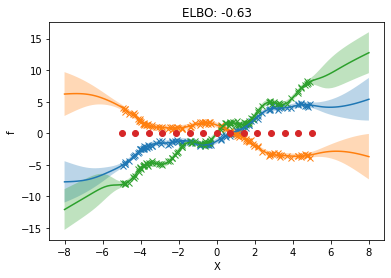

In [27]:
plot_model(m)

## Illustration of GPflow's multi-output capabilities
This section shows the inheritance structure in GPflow's multi-output framework.

### Multi-output kernels (MOK) class diagram
We include three multi-output kernels:
- `SharedIndependent`: This kernel is included mainly as an illustration of specifying a conditional using the multiple dispatch framework. The same functionality is provided by using a normal kernel and passing in multiple approximate posteriors by stacking `q_mu` and `q_sqrt`.
- `SeparateIndependent`: This kernel allows you to use different priors for each output GP.
- `LinearCoregionalization`: This kernel describes the prior of the linear model of coregionalization. As shown previously, this implementation supports various inducing point approximations.
![Multi-output kernels](./multioutput_kernels.svg)

We include several base classes. Two are noteworthy:
- `MultioutputKernel` is included to be the base class for all multi-output kernels.
- `IndepedentLatent` is the base class for all multi-output kernels which are constructed from independent latent processes. Including this kernel allows the specification of a default approximation method which, while not the most efficient, does take advantage of _some_ structure. It can be applied to _any_ kernel constructed from independent latent processes.

There is a similarity in the meaning of `SeparateIndependent` and `IndependentLatent`. Both kernels indicate that independent processes are used, and that $\mathbf{K}_{\bf uu}$ can therefore be represented as a `[L, M, M]` tensor. It could therefore be suggested that `SeparateIndependent` be the parent class of all "independent latent" kernels, instead of having a separate `IndependentLatent` class. We decided against this because:
- this would increase the complexity in specifying `conditionals()` for the otherwise simple multi-output kernels `SeparateIndependent` and `SharedIndependent`.
- we did not want to specify too much of an implementation in `IndependentLatent`, leaving implementation details to child classes. Using `SeparateIndependent` as the base class would force all child classes to be a `Combination` kernel.

### Multi-output inducing variables class diagram
![Multi-output features](./multioutput_features.svg)

#### Inducing points
The goal of this class is to provide inducing variables that can be used with _any_ kernel, even if the method ends up being slow.

The multiouput framework extends `InducingPoints` to work with multi-output kernels. Just like for single-output kernels, we want `InducingPoints` to work for all `MultioutputKernel`s. We do this by defining `InducingPoints` to take _all_ outputs for specific inducing inputs as inducing variables.

#### Fallback shared/separate independent inducing variables
The goal of these classes is to provide a reasonably efficient implementation for kernels that give exploitable independence structure in the prior of inducing variables (that is, subclasses of `IndependentLatent`), while only needing to implement `Kuu()` and `Kuf()` methods.

#### Shared/separate independent inducing variables
The goal of these classes is to provide the most efficient code path for kernels that allow exploiting independence structure in the prior of inducing variables.

For more specialized multi-output kernels (i.e. `{Shared|Separate}Independent` or `LinearCoregionalization`) we define `{Shared|Separate}IndependentInducingVariables`. These wrap (a list of) single-output inducing variables to define groups of a-priori independent inducing variables, which leads to a $\mathbf{K}_{\bf uu}$ that can be represented as a `[L, M, M]` tensor. We saw the use of these previously.

`{Shared|Separate}IndependentInducingVariables` inherit from `Fallback{Shared|Separate}IndependentInducingVariables`, so the multiple dispatch will fall back on the slower but general implementation.

### Implemented combinations
Multiple dispatch is applied to both `Kuu()`, `Kuf()`, and `conditional()`. The return values of the covariances can therefore be tailored to a specific implementation of `conditional()`. The following table lists combinations which are currently available in GPflow. Thanks to the multiple dispatch code, implementing your own outside of GPflow should require only a small amount of code!

| Inducing variable class                                      | Kernel                  | Kuu           | Kuf           | conditional                         | note                                                                                                                                                                                                                                                                                           |
|----------------------------------------------|-------------------------|---------------|---------------|-------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `InducingPoints`                               | `MultioutputKernel`       | `[M, P, M, P]` | `[M, P, N, P]` | `inducing_point_conditional()`, which calls `fully_correlated_conditional()`       | Works for all kernels, but might be very inefficient. In this case `q_mu` and `q_sqrt` should have shapes of `[1, MP]` and `[1, MP, MP]`  |
| `SharedIndependentInducingVariables`           | `SharedIndependent`       | `[M, M]`         | `[M, N]`         | `shared_independent_conditional()`, which calls `base_conditional()`                    | The combination of these two classes is in a sense redundant, because we can achieve the same behavior by using the single output Kernel and InducingVariable classes. They are added for illustrative purposes. Thanks to the conditional dispatch, the most efficient code path is used. |
| `SeparateIndependentInducingVariables`         | `SharedIndependent`       | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times               | We loop P times over the `base_conditional()`         |
| `SeparateIndependentInducingVariable`         | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     |  `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`           |
| `SharedIndependentInducingVariables`           | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`        |
| `FallbackSharedIndependentInducingVariables`   | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()` |
| `FallbackSeparateIndependentInducingVariable` | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()`  |
| `SharedIndependentInducingVariables`           | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | `coregionalization_conditional()`, which calls `base_conditional()`                    | This is the most efficient implementation for linear coregionalization. The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |
| `SeparateIndependentInducingVariables`         | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | base_conditional                    | This is the most efficient implementation for linear coregionalization. The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |

## Debugging: introspect

Given all these possibilities it can be hard to determine which conditional will be called for which set of kernel and inducing variable. The following method lets you proactively introspect which implementation will be executed. This can be useful when debugging new code.

In [28]:
def inspect_conditional(inducing_variable_type, kernel_type):
    """
    Helper function returning the exact implementation called
    by the multiple dispatch `conditional` given the type of
    kernel and inducing variable.

    :param inducing_variable_type:
        Type of the inducing variable
    :param kernel_type:
        Type of the kernel

    :return: String
        Contains the name, the file and the linenumber of the
        implementation.
    """
    import inspect
    from gpflow.conditionals import conditional

    implementation = conditional.dispatch(object, inducing_variable_type, kernel_type, object)
    info = dict(inspect.getmembers(implementation))
    return info["__code__"]


# Example:
inspect_conditional(
    gpf.inducing_variables.SharedIndependentInducingVariables, gpf.kernels.SharedIndependent
)

<code object shared_independent_conditional at 0x7f3b280be6f0, file "/home/circleci/project/GPflow/gpflow/conditionals/multioutput/conditionals.py", line 44>

## Further Reading:
- [A simple demonstration of coregionalization](./coregionalisation.ipynb), which details other GPflow features for multi-output prediction without fully observed outputs.